<center style="font-size:1.75em;">A Journey through the Atlas Lions' Triumphs: A Historical Data Analysis of the Morocco National Football Team</center>

<center><img src="https://i.postimg.cc/Y2Z5k8HH/Maroc.jpg" alt="Your Image"></center>

**Introduction:**

In this data analysis project, we'll be taking a closer look at the historical performance of the Morocco National Football Team. The analysis will primarily be *descriptive*, providing insights into key statistics that have shaped the team's journey. Additionally, we'll incorporate *simulation techniques* to explore hypothetical scenarios of binary betting , adding an engaging dimension to our findings. Join us as we delve into the numbers and narratives that define the *Atlas Lions' presence* on the global football stage.

[For this analysis project we will use following databases available on Kaggle](https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017/c)


**Warning:**

This data analysis project includes an exploration of betting scenarios and outcomes. It is important to note that discussions related to betting involve financial risks, and any strategies or simulations presented here are for informational and analytical purposes only. Engaging in actual betting should be approached responsibly, and individuals are advised to be aware of the legal implications and risks associated with gambling activities in their respective jurisdictions. The primary objective of this analysis is to examine historical football performance and draw insights rather than to encourage or endorse any form of gambling. 


### 1- Data cleaning and processing : 

In [1]:
#importing dependancies 

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import random
import os
import warnings
from scipy.stats import chi2_contingency
import scipy.stats as stats

In [2]:
warnings.filterwarnings("ignore") # ignore warnings that show on top of plots

In [3]:
#Importing data 

df_matches = pd.read_csv(r"D:\Bureau 1507\results.csv")
df_scorrers=pd.read_csv(r"D:\Bureau 1507\goalscorers.csv")

In [4]:
#checking data structure 

df_matches.head(2)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False


In [5]:
#checking data structure 

df_scorrers.head(2)

,date,home_team,away_team,team,scorer,minute,own_goal,penalty
0,1916-07-02,Chile,Uruguay,Uruguay,José Piendibene,44.0,False,False
1,1916-07-02,Chile,Uruguay,Uruguay,Isabelino Gradín,55.0,False,False


In [6]:
#data exploration

# checking data infos :

df_matches.info()

display("--------------------------------------------------------")

df_scorrers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44691 entries, 0 to 44690
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        44691 non-null  object
 1   home_team   44691 non-null  object
 2   away_team   44691 non-null  object
 3   home_score  44691 non-null  int64 
 4   away_score  44691 non-null  int64 
 5   tournament  44691 non-null  object
 6   city        44691 non-null  object
 7   country     44691 non-null  object
 8   neutral     44691 non-null  bool  
dtypes: bool(1), int64(2), object(6)
memory usage: 2.8+ MB


'--------------------------------------------------------'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41008 entries, 0 to 41007
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       41008 non-null  object 
 1   home_team  41008 non-null  object 
 2   away_team  41008 non-null  object 
 3   team       41008 non-null  object 
 4   scorer     40959 non-null  object 
 5   minute     40750 non-null  float64
 6   own_goal   41008 non-null  bool   
 7   penalty    41008 non-null  bool   
dtypes: bool(2), float64(1), object(5)
memory usage: 2.0+ MB


In [7]:
#since dataset has infos about all national teams we will keep only the the data that intrests us ( Morocco National team) : 

df_matches = df_matches.loc[(df_matches["home_team"] == "Morocco") | (df_matches["away_team"] == "Morocco")]
df_scorrers = df_scorrers.loc[(df_scorrers["team"] == "Morocco")]

#reindexing the Dataframes

df_matches = df_matches.reset_index(drop=True)

df_scorrers = df_scorrers.reset_index(drop=True)



In [8]:
#taking a deeper look at the data / seeing all the competitions : 

df_matches.tournament.unique().tolist()

['Friendly',
 'FIFA World Cup qualification',
 'African Cup of Nations qualification',
 'FIFA World Cup',
 'African Cup of Nations',
 'Kuneitra Cup',
 'Beijing International Friendship Tournament',
 'Merdeka Tournament',
 'Nehru Cup',
 'Korea Cup',
 'Tournoi de France',
 'United Arab Emirates Friendship Tournament',
 'King Hassan II Tournament',
 'African Nations Championship',
 'African Nations Championship qualification',
 'Arab Cup']

In [9]:
#looking at the data we can see that it has even games by not only the A team , but also the A' and youth teams 
# that's why we will keep only FiFa dates/competitions that were played by the A team 
# ['Friendly','FIFA World Cup qualification','African Cup of Nations qualification', 'FIFA World Cup','African Cup of Nations']

tournament_to_keep =['Friendly','FIFA World Cup qualification','African Cup of Nations qualification', 'FIFA World Cup','African Cup of Nations']

df_matches = df_matches.loc[(df_matches["tournament"].isin(tournament_to_keep ))]

#with all the changes we need to reset the index for the database and drop oldindex : 

df_matches = df_matches.reset_index(drop=True)


In [10]:

#1- parsing the dates : 

df_matches["date"] = pd.to_datetime(df_matches["date"])
df_scorrers["date"] =pd.to_datetime(df_scorrers["date"])


In [11]:

#adding extra columns to use in our analysis

# ["result" = win , loss , draw ]
# ["Field advantage" : {0 : neutral field  ,1: home game , -1:away game}]
# ["cumulative winrate"] 
# ["goal diffrence"]

#------adding result column : 

df_matches.loc[(df_matches["home_score"] == df_matches["away_score"]) , "result" ] = "Draw"
df_matches.loc[(df_matches["home_team"] == "Morocco") & (df_matches["home_score"]>df_matches["away_score"]) ,"result"] = "Win"
df_matches.loc[(df_matches["home_team"] != "Morocco") & (df_matches["home_score"]>df_matches["away_score"]) ,"result"] = "Loss"
df_matches.loc[(df_matches["away_team"] == "Morocco") & (df_matches["home_score"]<df_matches["away_score"]) ,"result"] = "Win"
df_matches.loc[(df_matches["away_team"] != "Morocco") & (df_matches["home_score"]<df_matches["away_score"]) ,"result"] = "Loss"

#------adding field advantage : 

df_matches.loc[(df_matches.neutral == True) & (df_matches.country != "Morocco"),"field advantage"] = 0
df_matches.loc[(df_matches.neutral == False) & (df_matches.country != "Morocco"),"field advantage"] = -1
df_matches.loc[(df_matches.neutral == False) & (df_matches.country == "Morocco"),"field advantage"] = 1

#--------------adding a cumulative winrate column : 

cumulative_winrate=[]

wins = 0

winrate = 0 

for i in range (len(df_matches)) :
    
    if df_matches["result"][i] == "Win" : 
        
        wins = wins + 1 
        
        winrate = round(wins/(i+1)*100,2)
        
        cumulative_winrate.append(winrate)
    else :
        
        wins = wins
        
        winrate = round(wins/(i+1)*100,2)
        
        cumulative_winrate.append(winrate)

df_matches["cumulative winrate"]= cumulative_winrate

#Adding a goal diff column :

goal_diff=[]

for i in range (len(df_matches)) :
    
    Diff = int(df_matches["home_score"][i])-int(df_matches["away_score"][i])
    
    if Diff == 0 : 
        
        goal_diff.append(int(0))
    
    else : 
        
        if  (df_matches["result"][i] == "Win") & (Diff > 0) : 
            
            goal_diff.append(int(Diff))
            
        elif (df_matches["result"][i] == "win") & (Diff < 0) : 
            
            goal_diff.append(int(-Diff))
            
        elif (df_matches["result"][i] == "Loss") & (Diff < 0) : 
            
            goal_diff.append(int(Diff))
            
        else :
            
            goal_diff.append(int(-Diff))
            
df_matches["goal difference"]=goal_diff


In [12]:
#Checking structure after adding the columns :

df_matches.head(2)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,result,field advantage,cumulative winrate,goal difference
0,1958-04-03,Morocco,Libya,3,1,Friendly,Casablanca,Morocco,False,Win,1.0,100.0,2
1,1960-01-01,Morocco,Yugoslavia,0,5,Friendly,Casablanca,Morocco,False,Loss,1.0,50.0,-5


In [13]:
#droping neutral column 

df_matches.drop(columns=["neutral"],inplace=True)

In [14]:
#let's now perform a last check for null_values and duplicates : 

display(df_matches.isnull().values.sum()) #-------> test passed 

display(df_matches.duplicated(subset=["date"]).values.sum())#--------------> found one duplicated value


0

1

In [15]:
#let's understand the case of the duplicate and solve it : 

#Since our unique value that can't be duplicated is the date , that's why we will get the duplicates using it :

df_matches.loc[(df_matches["date"].duplicated() == True) , "date"]


85   1975-03-22
Name: date, dtype: datetime64[ns]

In [16]:
#understanding the problem : 

df_matches.loc[(df_matches["date"] == "1975-03-22")]


,date,home_team,away_team,home_score,away_score,tournament,city,country,result,field advantage,cumulative winrate,goal difference
84,1975-03-22,Morocco,Senegal,4,0,African Cup of Nations qualification,Fez,Morocco,Win,1.0,38.82,4
85,1975-03-22,Senegal,Morocco,2,1,African Cup of Nations qualification,Kaolack,Senegal,Loss,-1.0,38.37,-1


In [17]:
#after verifying the issue it appears that the two games were played on 2 different dates than the duplicated one and we will proceed to change them manually :  

df_matches.date.iloc[85]=  np.datetime64("1975-09-28")
df_matches.date.iloc[84]=np.datetime64("1975-09-14") 

#reparsing the dates 

df_matches["date"] = pd.to_datetime(df_matches["date"])

In [18]:
#Since we applied changes to data date we need to reorder the datebase by date  and reset the index :  

df_matches =df_matches.sort_values(by=["date"])
df_matches.reset_index(drop=True)

,date,home_team,away_team,home_score,away_score,tournament,city,country,result,field advantage,cumulative winrate,goal difference
0,1958-04-03,Morocco,Libya,3,1,Friendly,Casablanca,Morocco,Win,1.0,100.00,2
1,1960-01-01,Morocco,Yugoslavia,0,5,Friendly,Casablanca,Morocco,Loss,1.0,50.00,-5
2,1960-10-30,Morocco,Tunisia,2,1,FIFA World Cup qualification,Casablanca,Morocco,Win,1.0,66.67,1
3,1960-11-13,Tunisia,Morocco,2,1,FIFA World Cup qualification,Tunis,Tunisia,Loss,-1.0,50.00,-1
4,1960-12-11,Morocco,German DR,2,3,Friendly,Casablanca,Morocco,Loss,1.0,40.00,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
519,2022-12-14,France,Morocco,2,0,FIFA World Cup,Al Khor,Qatar,Loss,0.0,47.50,-2
520,2022-12-17,Croatia,Morocco,2,1,FIFA World Cup,Al Rayyan,Qatar,Loss,0.0,47.41,-1
521,2023-03-25,Morocco,Brazil,2,1,Friendly,Tangier,Morocco,Win,1.0,47.51,1
522,2023-03-28,Morocco,Peru,0,0,Friendly,Madrid,Spain,Draw,0.0,47.42,0


In [19]:
#rechecking for duplicates and null values 

display(df_matches.isnull().values.sum()) #-------> test passed 
display(df_matches.duplicated(subset=["date"]).values.sum())#--------> test passed 



0

0

In [20]:
#checking the data  :
df_matches.head(5)

,date,home_team,away_team,home_score,away_score,tournament,city,country,result,field advantage,cumulative winrate,goal difference
0,1958-04-03,Morocco,Libya,3,1,Friendly,Casablanca,Morocco,Win,1.0,100.00,2
1,1960-01-01,Morocco,Yugoslavia,0,5,Friendly,Casablanca,Morocco,Loss,1.0,50.00,-5
2,1960-10-30,Morocco,Tunisia,2,1,FIFA World Cup qualification,Casablanca,Morocco,Win,1.0,66.67,1
3,1960-11-13,Tunisia,Morocco,2,1,FIFA World Cup qualification,Tunis,Tunisia,Loss,-1.0,50.00,-1
4,1960-12-11,Morocco,German DR,2,3,Friendly,Casablanca,Morocco,Loss,1.0,40.00,-1


### 2- **Data Analysis :**

**Points to explore  :**

1. _The biggest goal difference loss and Win_
2. _The biggest scorring game/ The worst defending game_
3. _The easiest opponent/hardest opponent 


# <center>_**The biggest goal difference wins/losses**_</center>

In [21]:
#biggest goal diff win / Biggest goal diff loss -------> bgd ==== Biggest Goal difference

bgd_loss = min(df_matches["goal difference"])
bgd_win = max(df_matches["goal difference"])


#Extra info about the Matches : 

#-1----- Dates  and How many times it happened : 

dates_bgd_loss= df_matches.loc[(df_matches["goal difference"]== bgd_loss) , "date"].tolist()
dates_bgd_win = df_matches.loc[(df_matches["goal difference"]== bgd_win) , "date"].tolist()

recurence_bgd_loss = len(dates_bgd_loss) 
recurence_bgd_win  =len(dates_bgd_win)

#2-------Against what teams it happened : 

ot_bgd_loss =[]

ot_bgd_win=[]

for i in range (recurence_bgd_loss) : 

    ot_bgd_loss .append  ([element for element in ((df_matches.loc[(df_matches["goal difference"]== bgd_loss) ,("home_team" ,'away_team')]).iloc[i]) if element != "Morocco"])
    
for j in range (recurence_bgd_win) : 

    ot_bgd_win .append([element for element in ((df_matches.loc[(df_matches["goal difference"]== bgd_win) ,("home_team" ,'away_team')]).iloc[j])if element != "Morocco"])


#3----------What was the competition that it occured in : 

comp_bgd_loss =[]

comp_bgd_win=[]

for i in range (recurence_bgd_loss) : 

    comp_bgd_loss .append( df_matches.loc[(df_matches["goal difference"]== bgd_loss) ,'tournament' ].iloc[i]) 
    
for j in range (recurence_bgd_win) : 

    comp_bgd_win .append( (df_matches.loc[(df_matches["goal difference"]== bgd_win) ,'tournament' ].iloc[j]))
    

#Printable Output : 

print(f"the biggest goal difference loss is a {-bgd_loss} goals difference and the biggest Goal difference win is a {bgd_win} goals difference")

for i in range (recurence_bgd_loss) : 

    print(f"the loss with a difference of {-bgd_loss} goals happened for the {i+1} time  against  {ot_bgd_loss[i][0]} on the {dates_bgd_loss[i].date()}  in a {comp_bgd_loss[i]} game ")

for j in range (recurence_bgd_win) : 

    print(f"the win with a difference of {bgd_win} goals happened for  the {j+1} time  against  {ot_bgd_win[j][0]} on the {dates_bgd_win[j].date()}  in a {comp_bgd_win[j]} game ")

the biggest goal difference loss is a 5 goals difference and the biggest Goal difference win is a 7 goals difference
the loss with a difference of 5 goals happened for the 1 time  against  Yugoslavia on the 1960-01-01  in a Friendly game 
the win with a difference of 7 goals happened for  the 1 time  against  Togo on the 1979-06-24  in a African Cup of Nations qualification game 
the win with a difference of 7 goals happened for  the 2 time  against  DR Congo on the 1996-08-29  in a Friendly game 


## <center>_**The highest scoring/conceding games**_</center>

In [22]:
#finding the most goals scored and conceded in one game : 

Goals_scored =[]
Goals_conceded =[]

for i in range( len(df_matches)) : 

    if df_matches["home_team"][i] =="Morocco" :
        
        Goals_scored .append(df_matches["home_score"][i])
        Goals_conceded .append(df_matches["away_score"][i])
        
    else :
        
        Goals_scored .append(df_matches["away_score"][i])
        Goals_conceded .append(df_matches["home_score"][i])

Max_goals_scored = max(Goals_scored) #returns the maximum goals scored in one game
Max_goals_conceded = max(Goals_conceded)#returns the maximum goals conceded in on game

display(Max_goals_conceded)
display(Max_goals_scored)



5

7

In [23]:

#Before fetching for the best scoring and worst defending games we need to see it they correspond and the biggest win and loss with biggest goal_diff 
#for that we will get the dates of the best scorring and worst defending games and compare them to the dates the biggest win and loss with biggest goal_diff 
#since date is unique , if the dates match the games are the same

#dates of the best scoring games and worst defending games :

dates_best_scoring_game = df_matches.loc[((df_matches.home_score == Max_goals_scored) & \
    (df_matches.home_team == "Morocco")) | ((df_matches.away_score == Max_goals_scored) & (df_matches.away_team == "Morocco")) , "date"].tolist() #returns dates when morocco scored max goals
dates_worst_defending_game = df_matches.loc[((df_matches.home_score == Max_goals_conceded) &\
    (df_matches.home_team != "Morocco")) | ((df_matches.away_score == Max_goals_conceded) & (df_matches.away_team != "Morocco")) , "date"].tolist() #returns dates when morocco conceded max goals


display(dates_best_scoring_game)
display(dates_worst_defending_game)

[Timestamp('1979-06-24 00:00:00'), Timestamp('1996-08-29 00:00:00')]

[Timestamp('1960-01-01 00:00:00'), Timestamp('1967-02-22 00:00:00')]

In [24]:
#comparing dates of the best scoring games to the biggest goal difference wins : 

if dates_best_scoring_game == dates_bgd_win :
    
    print("games match")
    
else :
    
    print("games don't match")

games match


In [25]:
#since bigesst goal difference wins and best scorring games match :

dates_best_scoring_game = dates_bgd_win
recurence_best_scoring_game = recurence_bgd_win
ot_best_scoring_game = ot_bgd_win
comp_best_scoring_game=comp_bgd_win

#formulating printable output :

print(f"the maximum  goals Morocco National Team has scored  is {Max_goals_scored} goals")

for j in range (recurence_bgd_win) : 

    print(f"the best scoring games for morocco ended up with morocco scoring  {Max_goals_scored} goals . It happened for  the {j+1} time  against  {ot_best_scoring_game[j][0]} on the {dates_best_scoring_game[j].date()}  in a {comp_best_scoring_game[j]} game ")



the maximum  goals Morocco National Team has scored  is 7 goals
the best scoring games for morocco ended up with morocco scoring  7 goals . It happened for  the 1 time  against  Togo on the 1979-06-24  in a African Cup of Nations qualification game 
the best scoring games for morocco ended up with morocco scoring  7 goals . It happened for  the 2 time  against  DR Congo on the 1996-08-29  in a Friendly game 


In [26]:
#comparing dates of the worst defending games to the biggest goal difference losses : 

if dates_worst_defending_game == dates_bgd_loss :
    
    print("games match")
    
else :
    
    print("games don't match")

games don't match


In [27]:
#since worst defending games and the biggest goal difference losses don't match : 

dates_worst_defending_game  #dates of the worst defending games ----> already defined and fetched 

recurence_worst_defending_game = len(dates_worst_defending_game) #how many time the event happened 

#competions within the event happened : 

comp_worst_defending_game = df_matches.loc[((df_matches.home_score == Max_goals_conceded) & (df_matches.home_team != "Morocco")) | ((df_matches.away_score == Max_goals_conceded) & (df_matches.away_team != "Morocco")) , "tournament"].tolist()

#teams agains who the event happened : 

ot_worst_defending_game =  []

for i in range (recurence_worst_defending_game) : 
    
    ot_worst_defending_game.append([ element for element in ((df_matches.loc[((df_matches.home_score == Max_goals_conceded) & (df_matches.home_team != "Morocco")) | ((df_matches.away_score == Max_goals_conceded) & (df_matches.away_team != "Morocco")) , ("home_team","away_team")].iloc[i].tolist()))if element!="Morocco"])

#formulating printable output 

print(f"the maximum goals Morocco National Team has concedded  is {Max_goals_conceded} goals")

for j in range (recurence_worst_defending_game) : 

    print(f"the worst defending games for morocco ended up with morocco conceding  {Max_goals_conceded} goals . It happened for  the {j+1} time  against  {ot_worst_defending_game[j][0]} in {dates_worst_defending_game[j].date().year}  in a {comp_worst_defending_game[j]} game ")

the maximum goals Morocco National Team has concedded  is 5 goals
the worst defending games for morocco ended up with morocco conceding  5 goals . It happened for  the 1 time  against  Yugoslavia in 1960  in a Friendly game 
the worst defending games for morocco ended up with morocco conceding  5 goals . It happened for  the 2 time  against  Germany in 1967  in a Friendly game 


## <center>_**The easiest/Hardest opponent**_</center>

In [28]:
#Who did Morocco win against the most :

df_wins = df_matches.loc[df_matches["result"]=="Win"] #data of games where morocco won

wins_away = df_wins.loc[df_wins["home_team"] != "Morocco" , "home_team"].value_counts().to_dict()  #return a dict that contains teams against who morocco won away games

wins_home = df_wins.loc[df_wins["away_team"] != "Morocco" , "away_team"].value_counts().to_dict() #return a dict that contains teams against who morocco won home games

wins_dict = {team: wins_away.get(team, 0) + wins_home.get(team, 0) for team in set(wins_away) | set(wins_home)}  #additions the 2 dicts

Most_wins_against = max(wins_dict, key=lambda k: wins_dict[k]) #returns the team with the biggest team 

#who did Morocco lose against the most :

df_losses = df_matches.loc[df_matches["result"]=="Loss"]

losses_away = df_losses.loc[df_losses["home_team"] != "Morocco" , "home_team"].value_counts().to_dict() 

losses_home = df_losses.loc[df_losses["away_team"] != "Morocco" , "away_team"].value_counts().to_dict()

losses_dict = {team: losses_away.get(team, 0) + losses_home.get(team, 0) for team in set(losses_home) | set(losses_away)}

Most_losses_against = max(losses_dict, key=lambda k: losses_dict[k])

#who did morocco Draw against the most :

df_Draws = df_matches.loc[df_matches["result"]=="Draw"]

Draws_away = df_Draws.loc[df_Draws["home_team"] != "Morocco" , "home_team"].value_counts().to_dict() 

Draws_home = df_Draws.loc[df_Draws["away_team"] != "Morocco" , "away_team"].value_counts().to_dict()

Draws_dict = {team:Draws_away.get(team,0)+Draws_home.get(team,0) for team in set(Draws_away)| set(Draws_home)}

Most_Draws_against = max(Draws_dict, key=lambda k: Draws_dict[k])

#formatting printable output :

print(f"Morocco has won the most times against {Most_wins_against} with {wins_dict.get(Most_wins_against)} wins ")

print(f"Morocco has lost the most times against {Most_losses_against} with {losses_dict.get(Most_losses_against)} losses ")

print(f"Morocco has drew the most times against {Most_Draws_against} with {Draws_dict.get(Most_Draws_against)} draws")


Morocco has won the most times against Senegal with 19 wins 
Morocco has lost the most times against Senegal with 7 losses 
Morocco has drew the most times against Tunisia with 20 draws


## <center>_**Winrate Evolution Through History**_</center>

In [29]:
# a look at distribution of the winrate :


# the mean winrate :

print(f" the mean winrate is : {df_matches['cumulative winrate'].mean().round(2)}%")



 the mean winrate is : 43.01%


**Interpretation :** 

The 43.01% mean translates to :

* after every hundred games , the moroccan national team through out history won 43 games on average , this  lays under the theoritical mean of 50% .
* Important nuance : The winrate ratio treats losses and Draws equally . While in reality they are two distinct events . And to see the full picture the winrate needs to come side by side with the Drawrate , and that's the way to see how many loses where avoided and see the amplitude of the results of the team

<Axes: xlabel='cumulative winrate', ylabel='Density'>

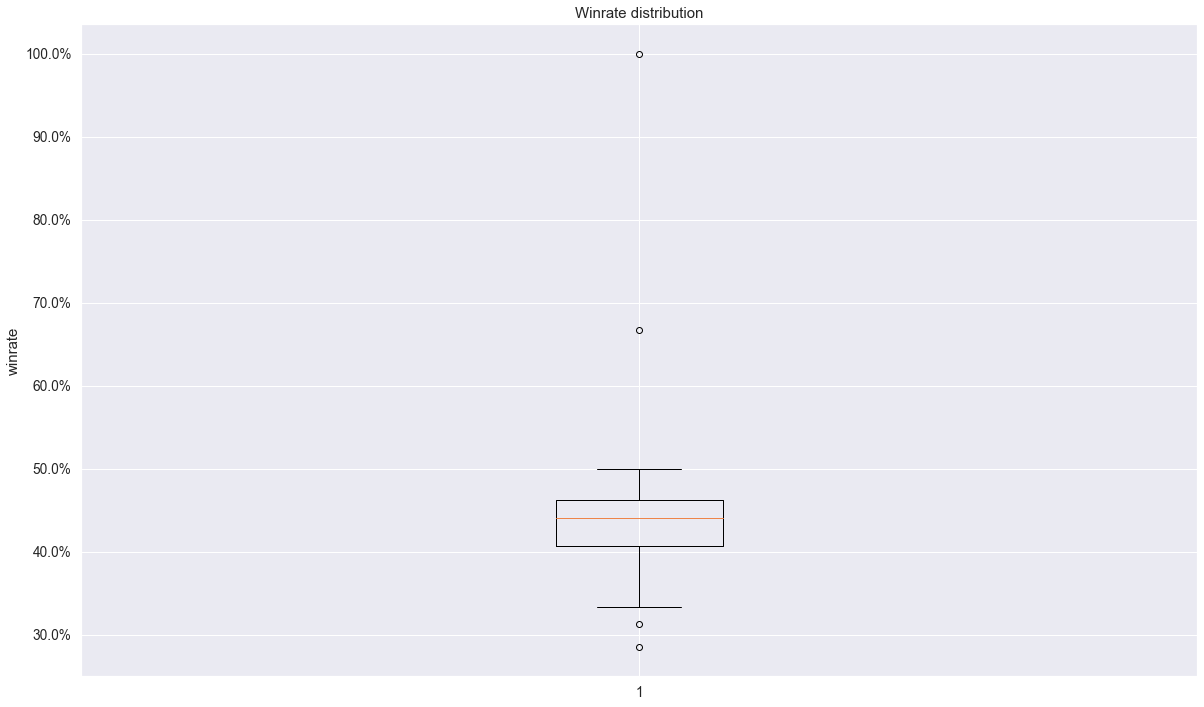

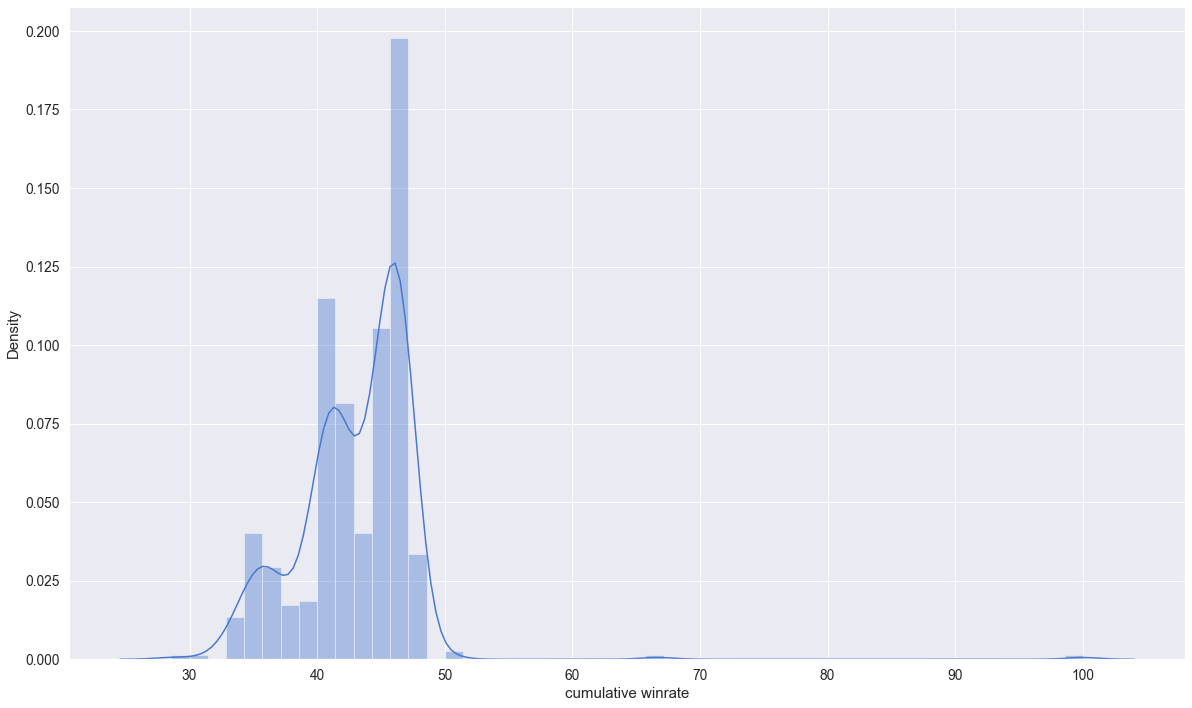

In [30]:


#Setting style for all future plots :

sns.set(style="darkgrid", palette="muted", font_scale=1.25)

#Plotting the cumulative winrate :

plt.figure(figsize=(20, 12))
plt.boxplot(df_matches["cumulative winrate"])
plt.title("Winrate distribution")
plt.ylabel("winrate")
plt.gca().set_yticklabels([f"{x}%" for x in plt.gca().get_yticks()])



#plotting distribution : 

plt.figure(figsize=(20,12))
sns.distplot(df_matches["cumulative winrate"])


<Axes: xlabel='cumulative winrate', ylabel='Density'>

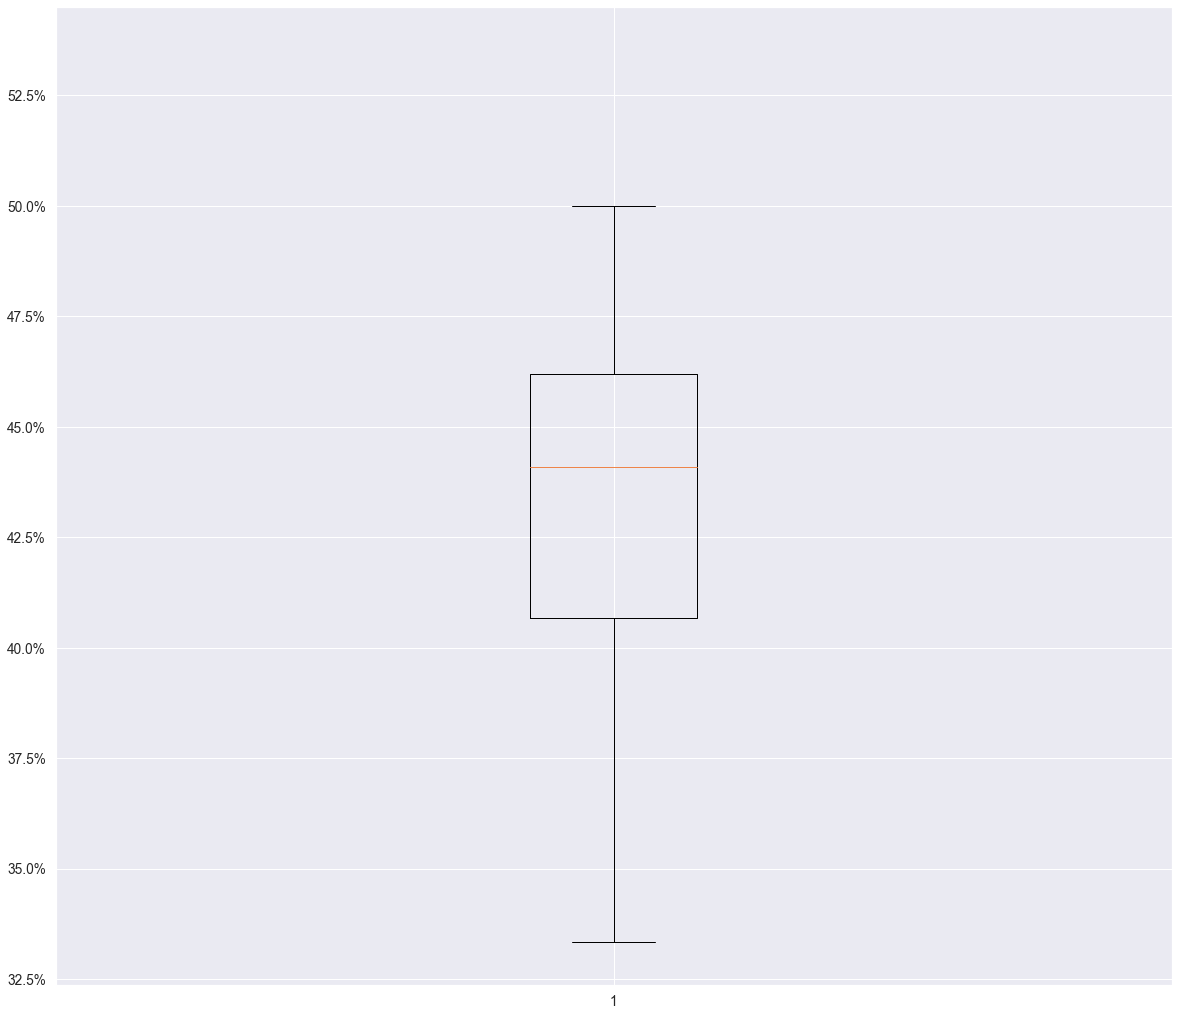

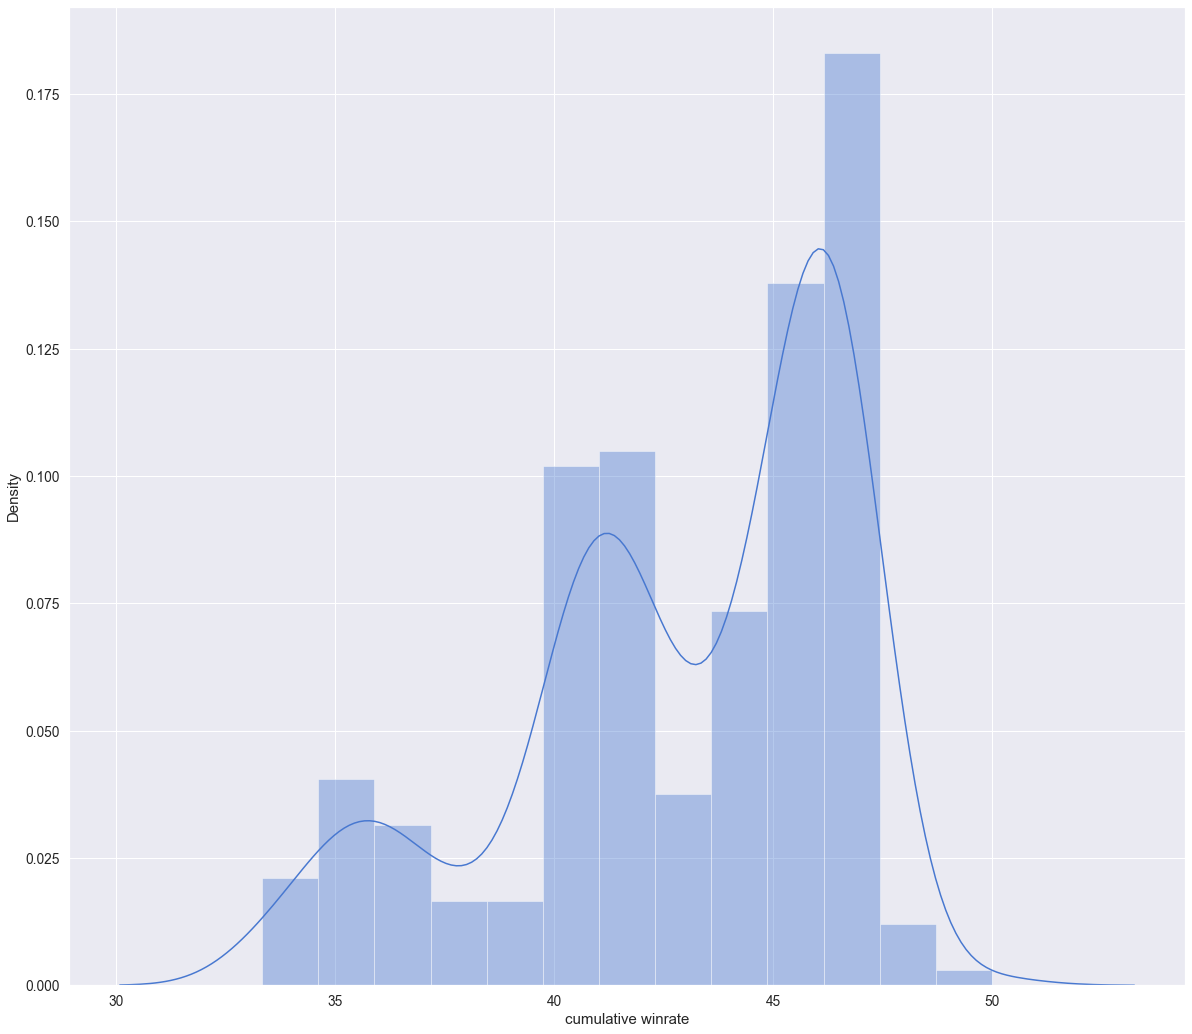

In [31]:
#After looking at the boxplot we can see some some extreme values (outliers ) , let's fix that  : 

#Let's detect the first and 3rd qunatile :

quantile1, quantile3=np.percentile(df_matches["cumulative winrate"],[25,75])

#defining the interquatile range :

iqr = quantile3- quantile1

#defining the upper and lower bound values  :

upper_bound_val = quantile3+(1.5*iqr)
lower_bound_val = quantile1-(1.5*iqr)

#let's now use the upper and lower bound values as limits :
plt.figure(figsize=(20,18))
plt.boxplot(df_matches["cumulative winrate"] )
plt.ylim([lower_bound_val,upper_bound_val])
plt.gca().set_yticklabels([f"{x}%" for x in plt.gca().get_yticks()])


#plotting distribution :

plt.figure(figsize=(20,18))
sns.distplot(df_matches.loc[(df_matches["cumulative winrate"]< upper_bound_val) & (df_matches["cumulative winrate"] > lower_bound_val) , "cumulative winrate"] )




Text(0, 44.40475, 'mean')

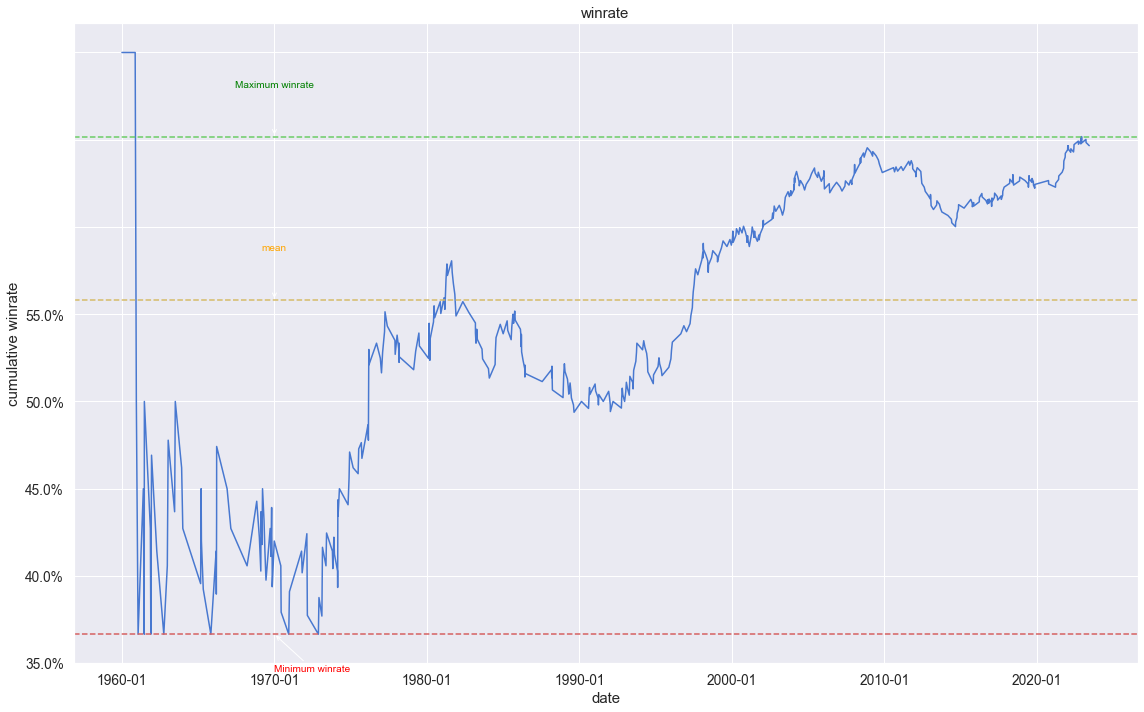

In [32]:
#let's now plot the Winrate without the outliers : 

df_matches_without_outliers = df_matches[(df_matches["cumulative winrate"]<=upper_bound_val) & (df_matches["cumulative winrate"] >=lower_bound_val)]

sns.lineplot(x=df_matches_without_outliers.date,y=df_matches_without_outliers["cumulative winrate"]).set_title("winrate")
plt.gca().set_yticklabels([f"{x}%" for x in plt.gca().get_yticks()] )
plt.xticks(rotation=0)
plt.gcf().set_size_inches(16, 10)
plt.tight_layout()

date_format = mdates.DateFormatter('%Y-%m')
plt.gca().xaxis.set_major_formatter(date_format)

#calculating  the range : 

min_winrate = np.min(df_matches_without_outliers["cumulative winrate"])
max_winrate = np.max(df_matches_without_outliers[df_matches_without_outliers["cumulative winrate"]!= 50]["cumulative winrate"]) 
            #even if 50% is not considered an outlier statistically but it happened in .\
            #i chose to not take it into consideration for max winrate calculation since number of matcehs played  was not significant ! 
    
#plotting mix and max values and adding annotations : 
    
plt.gca().axhline(y=max_winrate, color='g', linestyle='--')
plt.gca().axhline(y=min_winrate, color='r', linestyle='--')
plt.gca().axhline(y=df_matches_without_outliers["cumulative winrate"].mean(),color='y',linestyle='--')

plt.annotate("Maximum winrate",xy=(0,max_winrate),xytext=(0,max_winrate+1.5),ha='center', va='center', color='Green', arrowprops=dict(facecolor='green', arrowstyle='->'))
plt.annotate("Minimum winrate",xy=(0,min_winrate),xytext=(0,min_winrate-1),va='center', color='red', arrowprops=dict(facecolor='green', arrowstyle='->') ) 
plt.annotate("mean",xy=(0,df_matches_without_outliers["cumulative winrate"].mean()),xytext=(0,df_matches_without_outliers["cumulative winrate"].mean()+1.5),ha='center', va='center', color='orange', arrowprops=dict(facecolor='green', arrowstyle='->'))



**How the Winrate Line Plot Reflects Moroccan History**

The plot can be divided into segments:

1. **From 1958 to the early '70s** (Morocco did play games before 1958, but it was in a very special colonial context): This period was characterized by very fluctuating results, as shown by the fluctuating winrate. This is considered normal for a team that is just starting to compete on an international level. Despite the challenging start, Morocco did manage to qualify for its first World Cup (1970 World Cup). Despite not performing at the desired level in the competition, this era marked the beginning of Morocco's first golden era.

2. **From the early '70s to the mid '80s**: After experiencing high-level competition in the 1970 World Cup, Morocco's results improved, and its winrate grew exponentially. During this golden era, the Moroccan nation celebrated many achievements, starting with winning the AFCON 1976 cup, qualifying for the 1986 World Cup, and achieving an impressive qualification to the 16th round as the first African country to do so.

3. **From the mid '80s to the early '90s**: After the impressive achievements in the World Cup, Morocco was quickly brought back to the reality of African football, marked by a weak performance in the 1988 AFCON organized in Morocco. The downtrend and weakness continued, culminating in Morocco not qualifying for the 1990 World Cup.

4. **From the early '90s to now**: Starting from the early '90s, Morocco's national team began to improve with a new generation of players, returning to a positive trajectory. They qualified for two consecutive World Cups (1994 and 1998) and reached the 2004 AFCON cup final, losing to Tunisia. While the overall trend is positive, results faltered for Morocco between 2008 and 2014, causing them to miss both the 2010 and 2014 World Cups. After this brief stagnation period, Morocco picked up its pace again, qualifying for the 2018 and 2022 World Cups, where they achieved their historical result, ranking 4th in the Qatar 2022 WC.





    

## <center>_**Results Broken Down by tournament**_</center>

,result
tournament,
Friendly,224
FIFA World Cup qualification,118
African Cup of Nations qualification,89
African Cup of Nations,70
FIFA World Cup,23


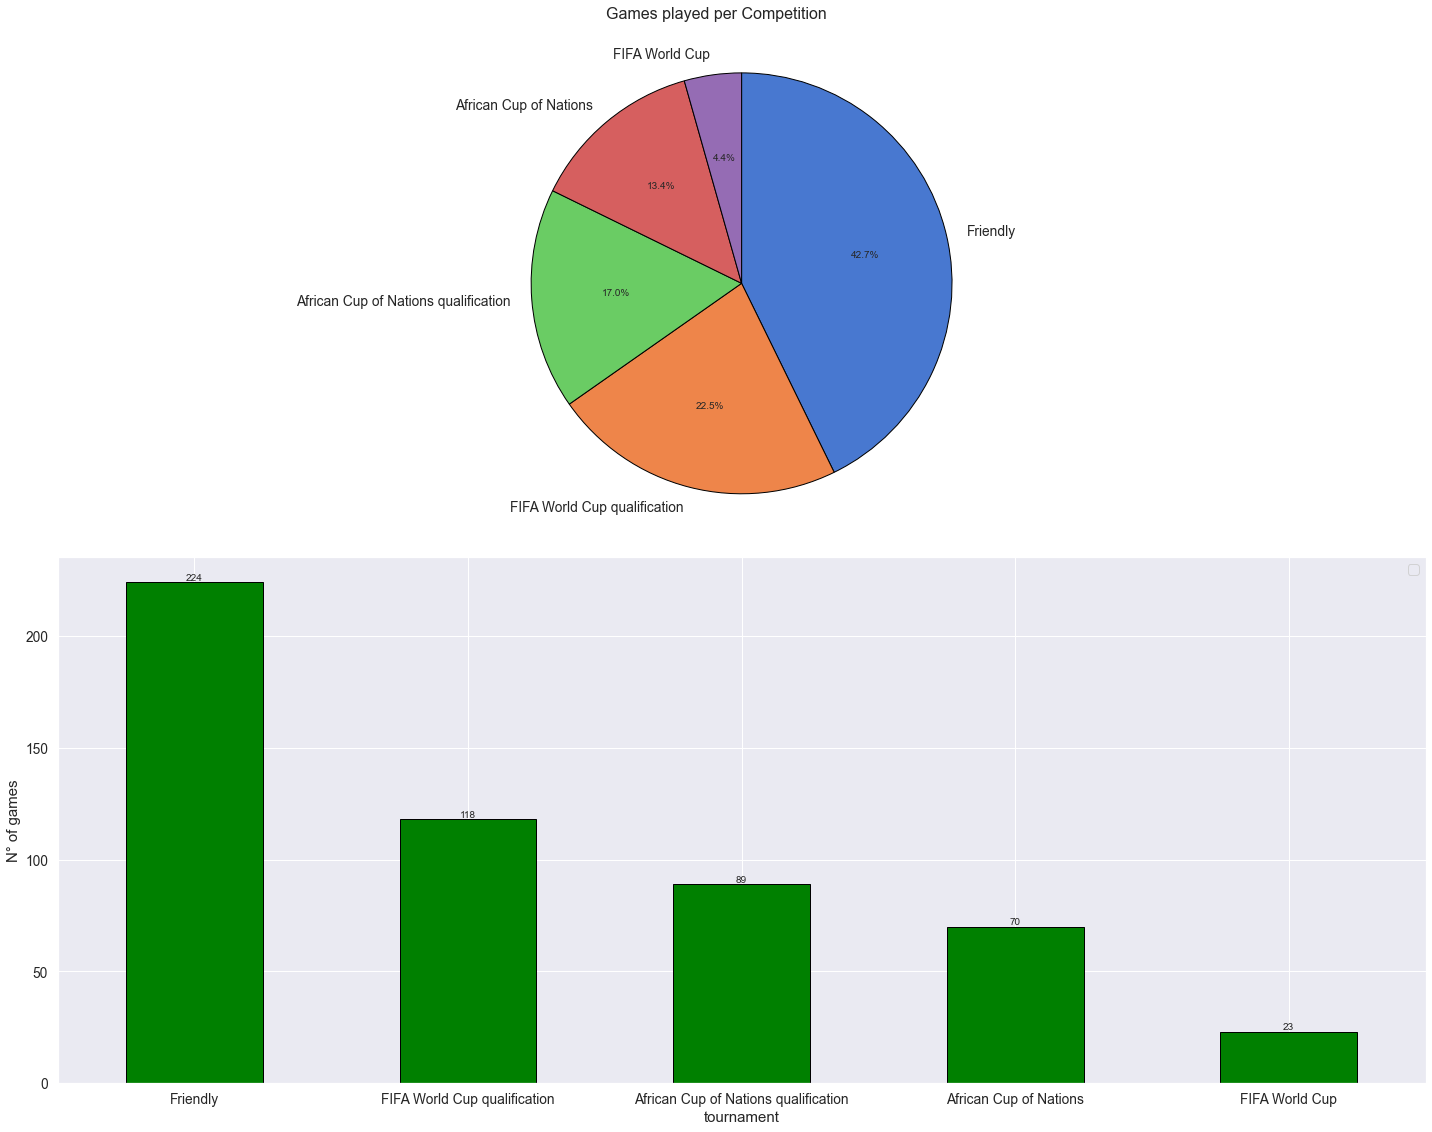

In [33]:
#Analysis by tournament  : 

#1  ---- games played in each tournament using grouby 

games_played_per_tournament = df_matches[['tournament',"result"]]\
    .groupby("tournament").count().sort_values(by="result",ascending=False)
    
display(games_played_per_tournament)

fig,axes = plt.subplots(2,1,figsize=(20,16))

ax1 = axes[0]

ax2 = axes[1]


fig.suptitle('Games played per Competition', fontsize=16)

#Plotting the games played as Bar :


games_played_per_tournament.plot(kind="bar", xlabel="tournament" , ylabel="N° of games" ,legend=None,color="green" , grid=True,edgecolor="black",ax=ax2  )
plt.xticks(rotation=0)
plt.tight_layout()

for i, count in enumerate(games_played_per_tournament["result"]):
    plt.gca().text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=10)
    
#Plotting the games played as a pieplot :

games_played_per_tournament.plot(kind="pie", autopct='%1.1f%%', startangle=90, counterclock=False ,ax=ax1 , subplots=True , legend=None ,ylabel="",wedgeprops={"edgecolor":'black'})
plt.tight_layout()
plt.xticks(rotation=0)
plt.legend( [])







**Read through Data:**

1. **Most Played Games:**
   - As expected, Friendly games are the most played.

2. **World Cup and Qualifications:**
   - World Cup qualification games are the second most played, surpassing AFCON qualification games. This can be explained by the historical format of World Cup qualifications, which involved playing a significantly higher number of games compared to AFCON qualifications. Before 2004, AFCON qualifications typically consisted of only six games.
   - The least played games are World Cup games.

3. **AFCON and Qualifiers:**
   - The difference in the number of games played between AFCON and AFCON qualifiers is minimal. This can be attributed to the unique format of AFCON, which was organized as a mini-tournament until the 90s. Even if teams did not perform well, they still played around five games, which is nearly the same number of games played in the qualifications. Additionally, this similarity can be justified by Morocco's less successful performances in the AFCON cup, where they often exited the tournament in its early stages, playing only a few games (3 to 4 games).






In [34]:


#1 let's now get the win/draw/losses per competition using pivot tables 

Results_per_competition = df_matches.pivot_table(index="tournament" , columns="result" ,aggfunc="size" )

display(Results_per_competition)



result,Draw,Loss,Win
tournament,,,
African Cup of Nations,24,19,27
African Cup of Nations qualification,18,20,51
FIFA World Cup,7,11,5
FIFA World Cup qualification,38,21,59
Friendly,59,59,106


The winrates/lossrates and Drawrates would be more representative than the count of wins/losses and Draws 

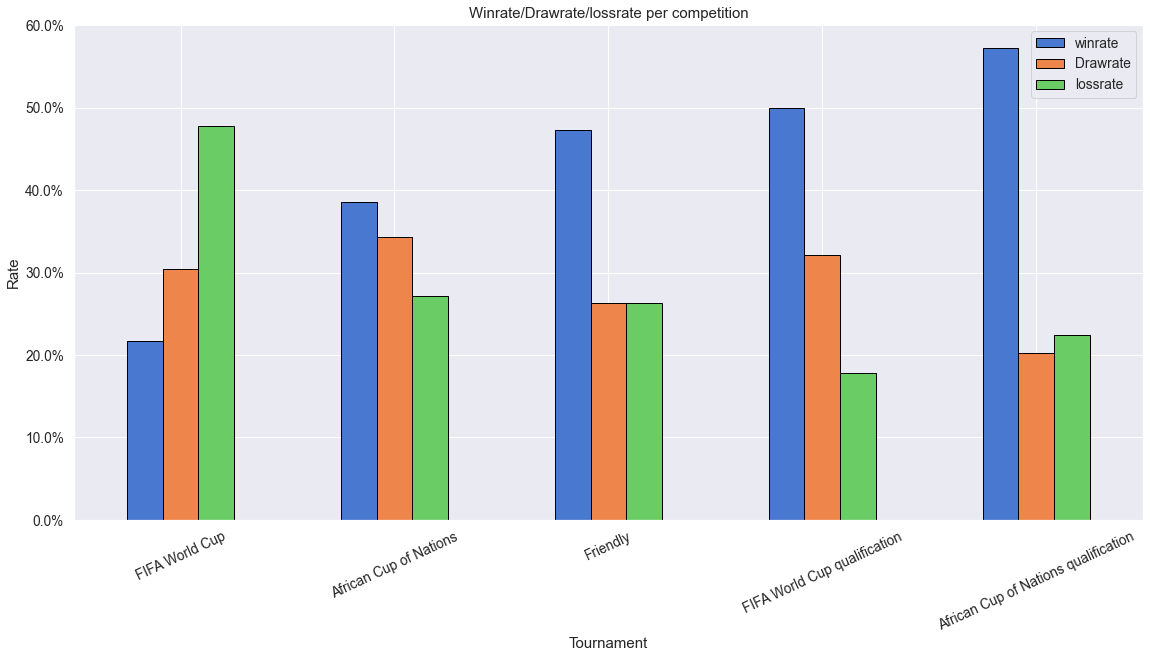

In [35]:
#lets measure the winrate/lossrate/Drawrate : 

Results_per_competition["winrate"] = ((Results_per_competition["Win"]/(Results_per_competition["Draw"]+Results_per_competition["Loss"]+Results_per_competition["Win"]))*100)\
    .round(2)

Results_per_competition["Drawrate"] =(( Results_per_competition["Draw"]/(Results_per_competition["Draw"]+Results_per_competition["Loss"]+Results_per_competition["Win"]))*100)\
    .round(2)

Results_per_competition["lossrate"] =(( Results_per_competition["Loss"]/(Results_per_competition["Draw"]+Results_per_competition["Loss"]+Results_per_competition["Win"]))*100)\
    .round(2)
    
    
Results_per_competition

#calculating some key metrics :

max_winrate = max(Results_per_competition.iloc[[i for i in range (len(Results_per_competition))]]["winrate"].tolist()) #maximum winrate
min_winrate = min(Results_per_competition.iloc[[i for i in range (len(Results_per_competition))]]["winrate"].tolist()) #minimum  winrate
max_drawrate = max(Results_per_competition.iloc[[i for i in range (len(Results_per_competition))]]["Drawrate"].tolist()) #max_drawrate
min_drawrate = min(Results_per_competition.iloc[[i for i in range (len(Results_per_competition))]]["Drawrate"].tolist())  #min_drawrate
max_lossrate = max(Results_per_competition.iloc[[i for i in range (len(Results_per_competition))]]["lossrate"].tolist()) #max_drawrate
min_lossrate = min(Results_per_competition.iloc[[i for i in range (len(Results_per_competition))]]["lossrate"].tolist())  #min_drawrate

Tn_max_winrate = (Results_per_competition [Results_per_competition["winrate"]==max_winrate].index.tolist())[0]  #tournamennt with maixmum winrate
Tn_min_winrate = (Results_per_competition [Results_per_competition["winrate"]==min_winrate].index.tolist())[0]  #tournamennt with minimum winrate
Tn_max_drawrate = (Results_per_competition [Results_per_competition["Drawrate"]==max_drawrate].index.tolist())[0] #tournamennt with maximum drawrate
Tn_min_drawrate = (Results_per_competition [Results_per_competition["Drawrate"]==min_drawrate].index.tolist())[0]    #tournament with minimum drawrate
Tn_max_lossrate = (Results_per_competition [Results_per_competition["lossrate"]==max_lossrate].index.tolist())[0] #tournamennt with maximum drawrate
Tn_min_lossrate = (Results_per_competition [Results_per_competition["lossrate"]==min_lossrate].index.tolist())[0]    #tournament with minimum drawrate


#plotting the differente rates per Results_per_competition : 
 

Table2=Results_per_competition[["winrate", "Drawrate" ,"lossrate"]].sort_values("winrate",ascending=True)

ax=Table2.plot.bar(title='Drawrate/winrate per competition', xlabel="Tournament", ylabel="Rate", edgecolor="black" ,figsize=(16, 8))


ax.set_xticks(range(len(Results_per_competition)))
ax.set_xticklabels(Table2.index, rotation=0)
ax.legend(title="")
ax.set_title('Winrate/Drawrate/lossrate per competition')
ax.set_xlabel('Tournament')
ax.set_ylabel('Rate')
plt.tight_layout()
plt.gca().set_yticklabels([f"{x}%" for x in ax.get_yticks()] )
plt.xticks(rotation=25)
plt.legend(bbox_to_anchor=(1, 1))




For a more visual comparaison , we will break the previous plot to 3 subplots : 

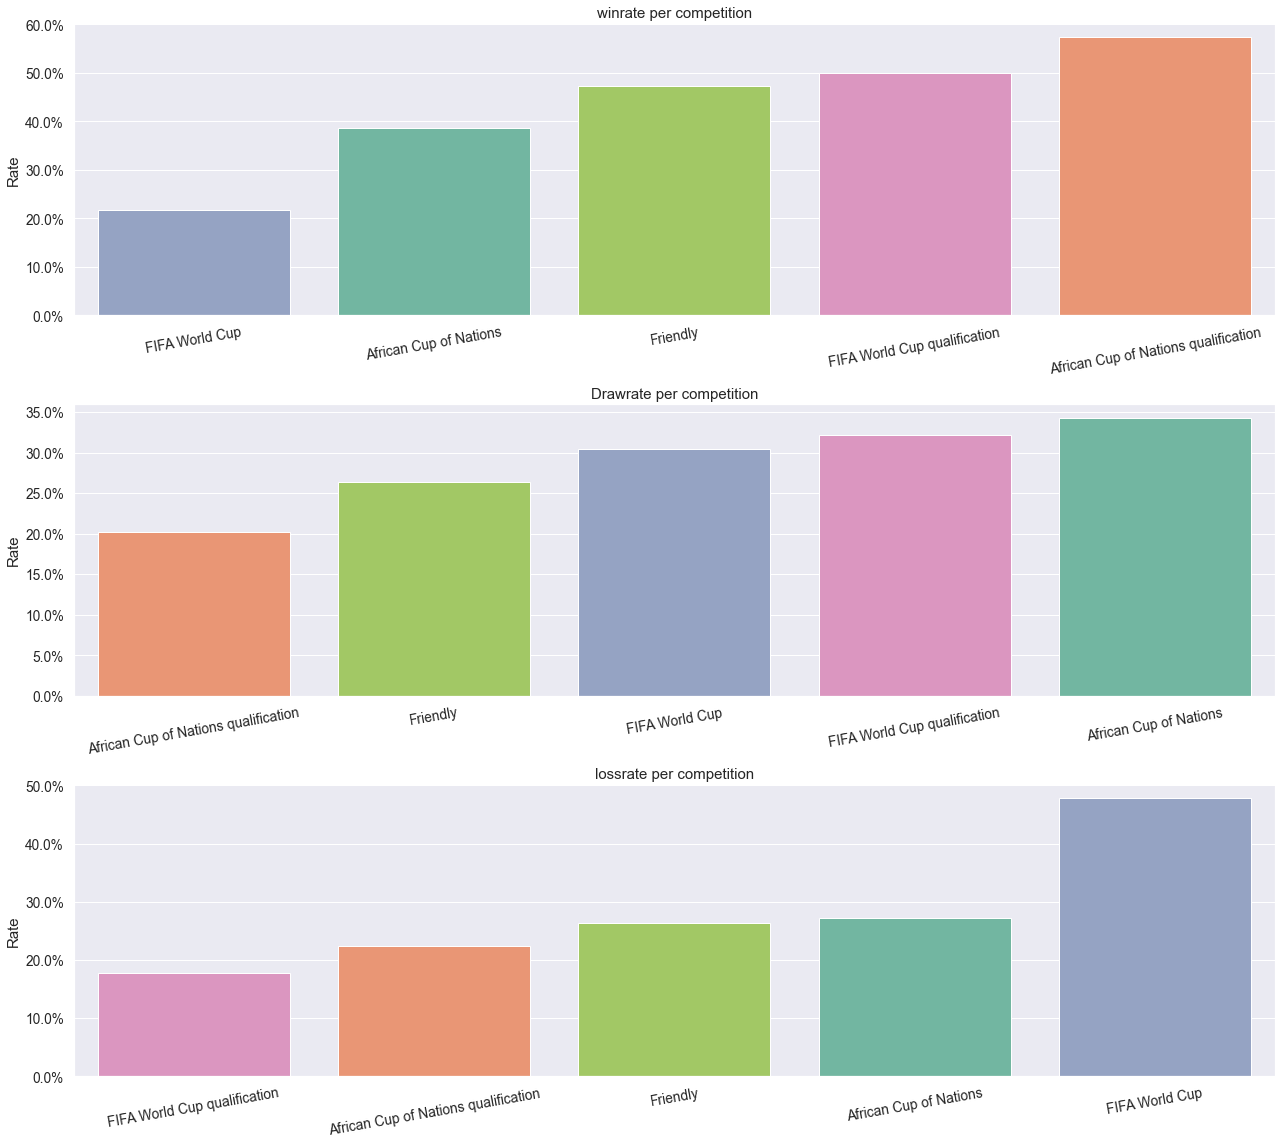

In [36]:


# Generate a coloring dict to use for map coloring  : 

colors = {competition: sns.color_palette('Set2', n_colors=len(Results_per_competition.index.tolist()))[i] for i, competition in enumerate(Results_per_competition.index.tolist())}


#plotting each rate individualy to be more visual :

fig,axes=plt.subplots(nrows=3, ncols=1, figsize=(18, 16))

for i,element in enumerate(["winrate","Drawrate","lossrate"]) : 
    
    Data_to_plot = Results_per_competition.sort_values(element,ascending=True)
    
    
    sns.barplot(x=Data_to_plot.index, y=element, data=Data_to_plot, 
                ax=axes[i],palette = [colors[competition]for competition in Data_to_plot.index])
    axes[i].set_yticklabels([f"{x}%" for x in axes[i].get_yticks()])
    axes[i].set_title(f"{element} per competition")
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Rate')
    axes[i].tick_params(axis='x', rotation=10)
    
plt.tight_layout()
    

In [37]:
#formating Printable output : 

print(f"when it comes to winrate , Morocco across all competitions , has a maximum winrate of {max_winrate}% and that's in the {Tn_max_winrate}\
    . When it comes to the minimum winrate , it's {min_winrate}% and that's in the {Tn_min_winrate}.")

print(f"when it comes to Drawrate , Morocco across all competitions , has a maximum draw rate  of {max_drawrate}% and that's in the {Tn_max_drawrate}\
    . When it comes to the minimum Drawrate , it's {min_drawrate}% and that's in the {Tn_min_drawrate}.")

print(f"when it comes to Lossrate , Morocco across all competitions , has a maximum loss rate  of {max_lossrate}% and that's in the {Tn_max_lossrate}\
    . When it comes to the minimum loss rate , it's {min_lossrate}% and that's in the {Tn_min_lossrate}.")

when it comes to winrate , Morocco across all competitions , has a maximum winrate of 57.3% and that's in the African Cup of Nations qualification    . When it comes to the minimum winrate , it's 21.74% and that's in the FIFA World Cup.
when it comes to Drawrate , Morocco across all competitions , has a maximum draw rate  of 34.29% and that's in the African Cup of Nations    . When it comes to the minimum Drawrate , it's 20.22% and that's in the African Cup of Nations qualification.
when it comes to Lossrate , Morocco across all competitions , has a maximum loss rate  of 47.83% and that's in the FIFA World Cup    . When it comes to the minimum loss rate , it's 17.8% and that's in the FIFA World Cup qualification.


**Read through the Data:**

- Despite the evolution of Moroccan football over the years, the gap between African football in general and Morocco, in particular, has remained significant. This justifies Morocco's performance in the World Cup, characterized by the lowest winrate and the highest loss rate.

- The highest winrate is observed in the AFCON qualifications, the same competition with the lowest draw rate and the second-lowest loss rate. This explains why Morocco has qualified for only 5 out of the 28 AFCON cups they entered qualifications for.

- The lowest loss rate is found in the World Cup qualifiers, the same tournament that boasts the second-best winrate and draw rate. However, these results are not proportionally reflected in the number of World Cups Morocco has attended (only 6 out of the 16 they entered qualifications for). This can be explained by the qualification format, which, until the last qualifications, included two phases: group stages and a final decisive knockout phase. Losing the knockout game meant not qualifying for the World Cup.

- Regarding the AFCON cup, this tournament has Morocco's highest draw rate, the second-lowest winrate, and the second-highest loss rate. This reflects the mediocre performance of Morocco in the AFCON cup, a fact often mentioned by previous coaches of the national team. They highlight how Morocco has consistently struggled, especially with sub-Saharan African football, citing both conditions and playstyle as contributing factors.



## <center>_**Results Broken Down by field advantage**_</center>

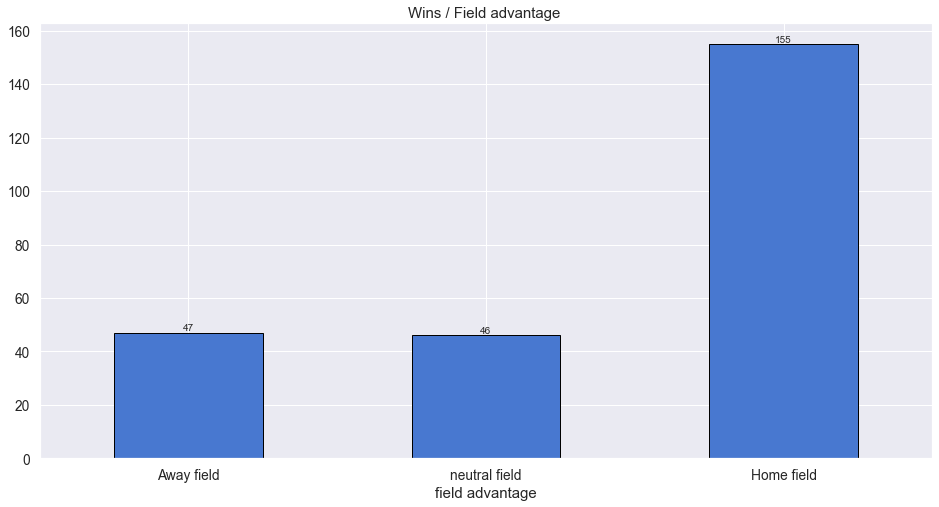

In [38]:
#let's see wins in field and outside : 

wins_field_advantage_per_competition = df_matches[(df_matches["result"] == "Win")][["result","field advantage","tournament"]].groupby(["field advantage",'tournament']).count().sort_values("result",ascending=True)

wins_field_advantage = df_matches[(df_matches["result"] == "Win")][["result","field advantage","tournament"]].groupby(["field advantage"]).count()

#let's plot the wins inside and outside :

wins_field_advantage["result"].plot(kind="bar" , edgecolor="black" , figsize=(16,8) , color="b") 

dic = {0:"Away field",1:"neutral field",2:"Home field"}

plt.gca().set_xticklabels([f"{dic.get(x)}" for x in plt.gca().get_xticks()])
plt.title("Wins / Field advantage ")
plt.xticks(rotation=0)

for i, count in enumerate(wins_field_advantage["result"]):
    plt.gca().text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=10)

In [39]:
# Winrates/Drawrates/lossrates by field advantage :
results_per_field = df_matches.pivot_table(index="field advantage" , columns="result" ,aggfunc="size" )



#calculating wirates , lossrates , drawrates for each case :

results_per_field["winrate"] = ((results_per_field["Win"]/(results_per_field["Draw"]+results_per_field["Loss"]+results_per_field["Win"]))*100)\
    .round(2)

results_per_field["Drawrate"] =((results_per_field["Draw"]/(results_per_field["Draw"]+results_per_field["Loss"]+results_per_field["Win"]))*100)\
    .round(2)

results_per_field["lossrate"] =(( results_per_field["Loss"]/(results_per_field["Draw"]+results_per_field["Loss"]+results_per_field["Win"]))*100)\
    .round(2)
    
display(results_per_field)
    


result,Draw,Loss,Win,winrate,Drawrate,lossrate
field advantage,,,,,,
-1.0,60,71,47,26.40,33.71,39.89
0.0,35,29,46,41.82,31.82,26.36
1.0,51,30,155,65.68,21.61,12.71


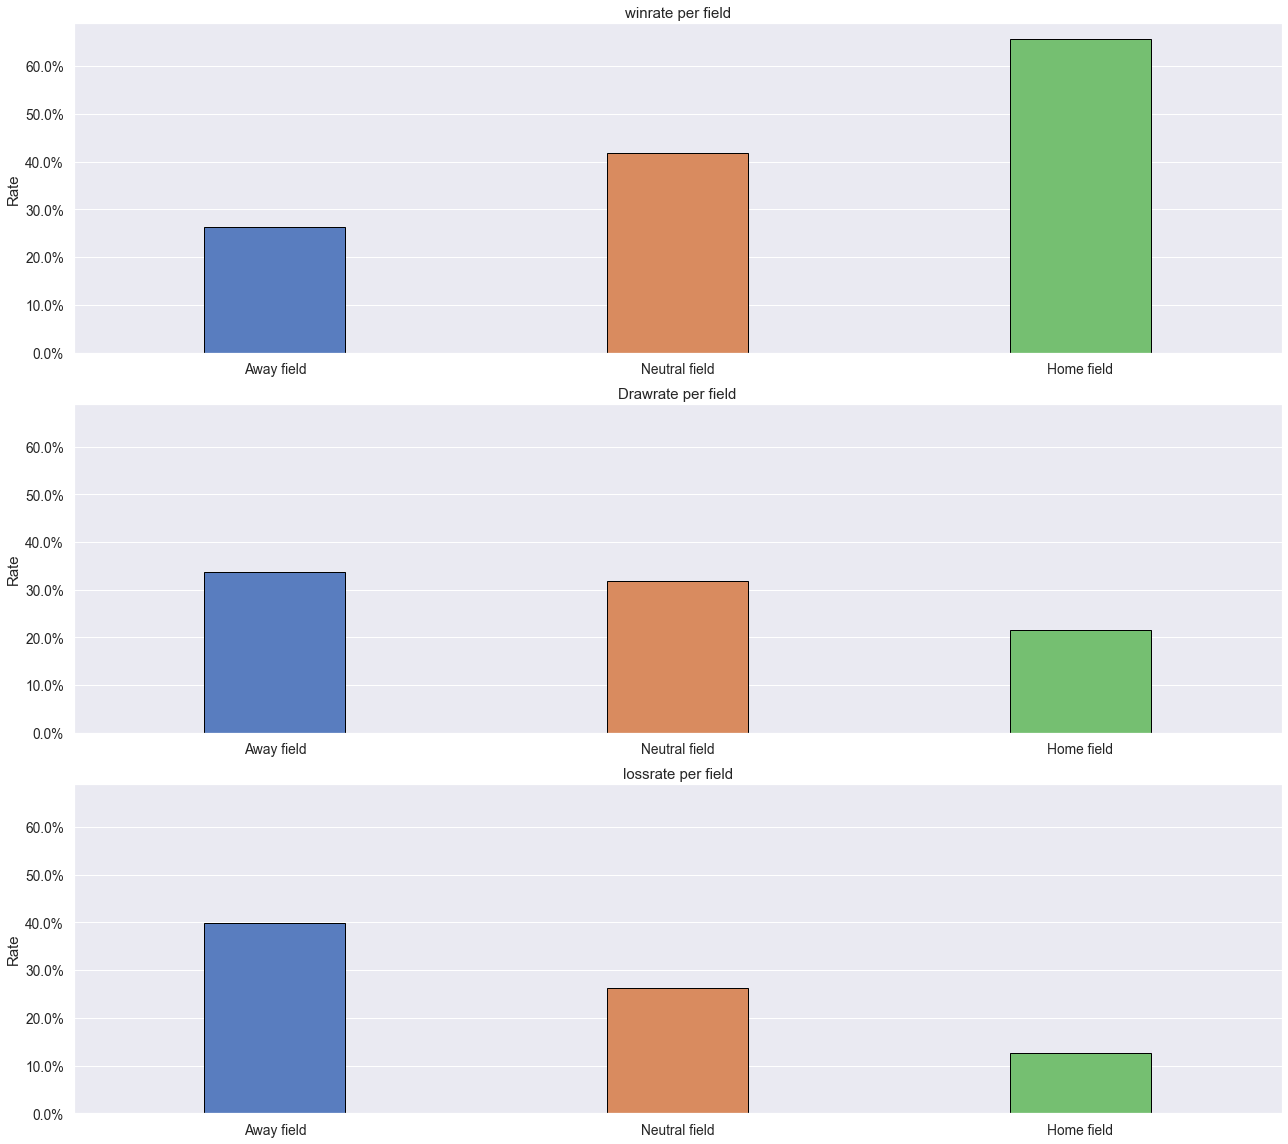

In [40]:


#plotting each rate individualy to be more visual :

#xticks map :

Field_mapping = {1.0:"Home field",0.0:"Neutral field",-1.0:"Away field"}

# Plotting :

fig,axes=plt.subplots(nrows=3, ncols=1, figsize=(18, 16),sharey=True)

for i,element in enumerate(["winrate","Drawrate","lossrate"]) : 
    
    sns.barplot(x=results_per_field.index, y=element, data=results_per_field, 
                ax=axes[i] , width=0.35,edgecolor="black")
   
    axes[i].set_yticklabels([f"{x}%" for x in axes[i].get_yticks()])
    axes[i].set_title(f"{element} per field")
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Rate')
    
    #Putting xticks based on their poistion 
    x_positions = range(len(results_per_field.index))
    x_labels = [Field_mapping.get(advantage) for advantage in results_per_field.index]
    
    axes[i].set_xticks(x_positions)
    axes[i].set_xticklabels(x_labels)
   
    
plt.tight_layout()

**Plot Reading:**

Observing the plot, it's evident that Morocco's highest winrate occurs in home games, while the lowest is in away games. Conversely, the highest loss rate is in away games, and the lowest loss rate is in home games. This suggests an association between the results variable and the playing field.



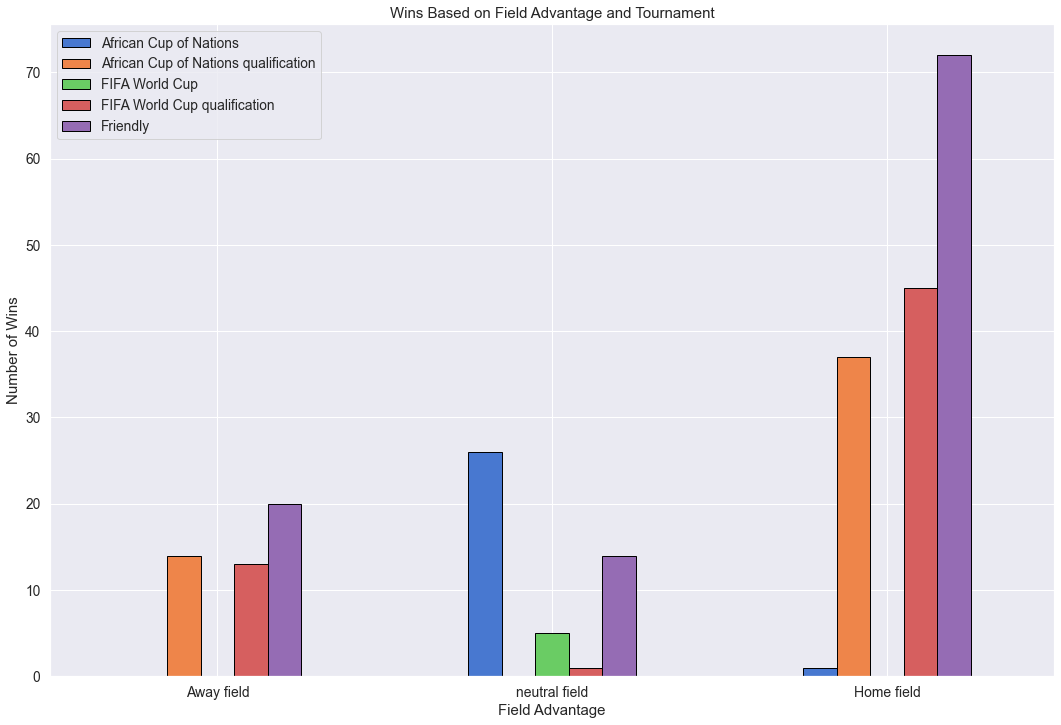

In [41]:
wins_field_advantage_per_competition.unstack().plot(kind='bar', stacked=False, edgecolor='black',figsize=(18,12))

plt.title('Wins Based on Field Advantage and Tournament')
plt.xlabel('Field Advantage')
plt.ylabel('Number of Wins')
plt.xticks(rotation=0,fontsize=14)  

plt.legend(title='Tournament')  

dic = {-1.0:"Away field",0.0:"neutral field",1.0:"Home field"}

#setting x labels : 

x_labels = [dic[label] for label in wins_field_advantage_per_competition.unstack().index.get_level_values('field advantage')]

plt.xticks(ticks=range(len(x_labels)), labels=x_labels)

#setting legend labels ( letting the standard legend options uses columns as xlabels but since this an unstacked table , the column name returns and intersection of (result,tournament ))

legend_labels = [col[1] for col in wins_field_advantage_per_competition.unstack().columns]

plt.legend(labels=legend_labels)





**Highlights of the Plot:**

- Logically, and besides friendly games, no tournament should be present in all three fields (home, away, and neutral) unless Morocco already organized one of the neutral tournaments (World Cup, AFCON). We observe that there is a home game in the AFCON, indicating that Morocco hosted an edition of AFCON.

- As expected, home wins in friendly games and qualifications for both the World Cup and the AFCON are higher than wins away.

- Unexpectedly, Morocco has won more friendly games in away fields than in neutral ones , and that might be interpreted as the home/away factor not being important in friendly games




## <center>_the Afcon oragnised in Morocco_</center>

In [42]:
#How did morocco perform in the african cup of nations he hosted :

#   1-----when was the competition hosted in morocco :

Date_Afcon_in_morocco = df_matches.loc[(df_matches["tournament"] =="African Cup of Nations") & (df_matches["field advantage"]== 1),"date"].head(1).tolist()[0].year

#   2 -----in what cities did morocco play during this competition : 

Cities_afcon_in_morocco = df_matches.loc[(df_matches["tournament"] =="African Cup of Nations") & (df_matches["field advantage"]== 1),"city"].unique().tolist()

#   3-----how did morocco perform :

Games_played_afcon_in_morocco = df_matches.loc[(df_matches["tournament"] =="African Cup of Nations") & (df_matches["field advantage"]== 1),"date"].size

Games_won_afcon_in_morocco = df_matches.loc[(df_matches['tournament'] =='African Cup of Nations') & (df_matches['field advantage']== 1) & (df_matches['result'] =='Win')  ,'date'].\
    size

Winrate__afcon_in_morocco= f"{((Games_won_afcon_in_morocco)/Games_played_afcon_in_morocco)*100}%"
    
#formatting printable output :


print(f"Morocco hosted the African Nations Cup in {Date_Afcon_in_morocco}")
print(f"During this competition morocco played {Games_played_afcon_in_morocco} games in the following cities : {Cities_afcon_in_morocco[0]}")
print(f"Unfortunately , the team played a disasterous competition winning only {Games_won_afcon_in_morocco} game out of the {Games_played_afcon_in_morocco} played , wich corresponds to {Winrate__afcon_in_morocco} winrate")   

Morocco hosted the African Nations Cup in 1988
During this competition morocco played 5 games in the following cities : Casablanca
Unfortunately , the team played a disasterous competition winning only 1 game out of the 5 played , wich corresponds to 20.0% winrate


## <center>_**Relationship between field advantage and results**_</center>

**Based on the previous analysis of results broken down by field advantage, we can guess that there might be a relationship between the results and the field advantage. Let's see if the two variables are associated using statistical tests.**


In [43]:
#taking the two categorical variables  of field advantage and result and studying their relationship to see if they are related and we will do that using the chi square test 

# the null hypothesis of the chi square test is that the 2 variables are not associated.

#creating contingency table :

Contingency_field_result=pd.crosstab(df_matches["result"],df_matches["field advantage"])

#performing chi test :

chi2_result , p, dof, expected = chi2_contingency(Contingency_field_result)

print(f"Chi-square statistic: {chi2_result}")
print(f"P-value: {p}")


Chi-square statistic: 70.41391693600214
P-value: 1.8561123336860657e-14


**Chi square test results :**

With the chi square result being high (70.41) and the P-Value being less that the significance degree of 0.05 we can reject the null hypothesis and say that the chi test represents strong evidence that the two variables ( Field advantage and results) are highly associated.


In [44]:
#Since the two variables are categorical and chi test indicates that they are associated let's use the Cramer's V to measure their association :

n = Contingency_field_result.sum().sum()
k = Contingency_field_result.shape[0]
r = Contingency_field_result.shape[1]

#Calculating the cramers coeff  :

V = np.sqrt(chi2_result / (n * min(k-1, r-1))).round(2)

print(V)


0.26


**_The Cramer's cofficient indicates a moderate association between the two variables._**

Question : What happens if we turn our variables into only binary ones ? ( Making the result variable into loss = 0 and win or draw = 1 and not considering the neutral field , and only keeping home and away fields )

In [45]:
df_matches_contingence = df_matches.loc[df_matches["field advantage"].isin([1.0,-1.0]),("result","field advantage")] #getting the data we need
df_matches_contingence['binary_result'] = ['Loss' if result == 'Loss' else 'Win/Draw' for result in df_matches_contingence['result']]#turning the result variable to a binary variable
df_matches_contingence.reindex()

,result,field advantage,binary_result
0,Win,1.0,Win/Draw
1,Loss,1.0,Loss
2,Win,1.0,Win/Draw
3,Loss,-1.0,Loss
4,Loss,1.0,Loss
...,...,...,...
508,Loss,-1.0,Loss
509,Win,1.0,Win/Draw
510,Win,1.0,Win/Draw
521,Win,1.0,Win/Draw


In [46]:
#Applying the chi square and the Cramer's V to measure the association :

#creating contingency table :

Contingency_field_result2=pd.crosstab(df_matches_contingence["result"],df_matches_contingence["field advantage"])

#performing chi test :

chi2_result2 , p, dof, expected = chi2_contingency(Contingency_field_result2)

print(f"Chi-square statistic: {chi2_result2}")
print(f"P-value: {p}")

#Since the two variables are categorical and chi test indicates that they are associated let's use the Cramer's V to measure their association :

n = Contingency_field_result2.sum().sum()
k = Contingency_field_result2.shape[0]
r = Contingency_field_result2.shape[1]

#Calculating the cramers coeff  :

V = np.sqrt(chi2_result2 / (n * min(k-1, r-1))).round(2)

print(V)


Chi-square statistic: 68.33140931857112
P-value: 1.4521885097469304e-15
0.41


**Interpretation:**

Looking at the result column as a binary variable (Loss and not loss), excluding the neutral field reveals a stronger association between the result and the field.

As observed in the plots and the statistical tests, results are highly related to the field advantage. In other terms, it's more probable for Morocco to win or draw when playing in front of their crowd than outside. This can be attributed to the arousal that a crowd cheering for them provides, enhancing their performance.


## <center>_**Performance and cities**_</center>

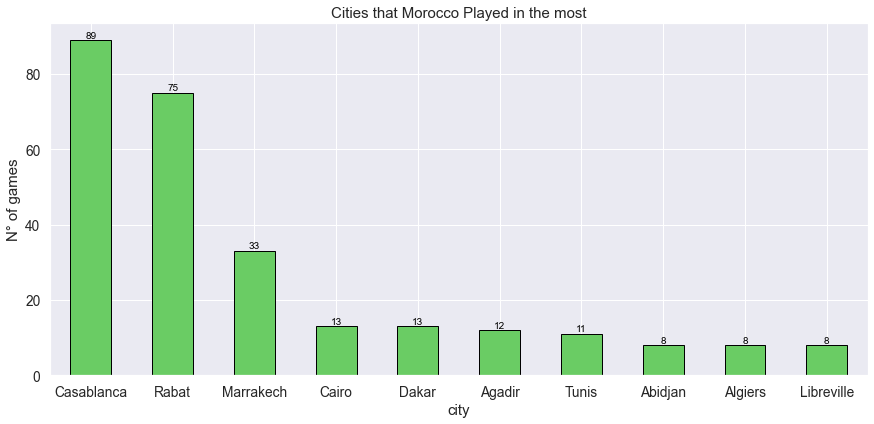

In [47]:
#what are the cities where morocco played the most  

Top_cities = df_matches["city"].value_counts().head(10)

Top_cities.plot(kind="bar" , color="g" ,edgecolor="black",figsize=(12,6))
plt.title("Cities that Morocco Played in the most")
plt.xticks(rotation=0)
plt.tight_layout()
plt.ylabel("N° of games")

for i , count in enumerate(Top_cities) :
    plt.gca().text(i,count+0.1,str(count),ha='center', va='bottom', fontsize=10, color='black')


Text(21.375, 0.5, 'N° of games')

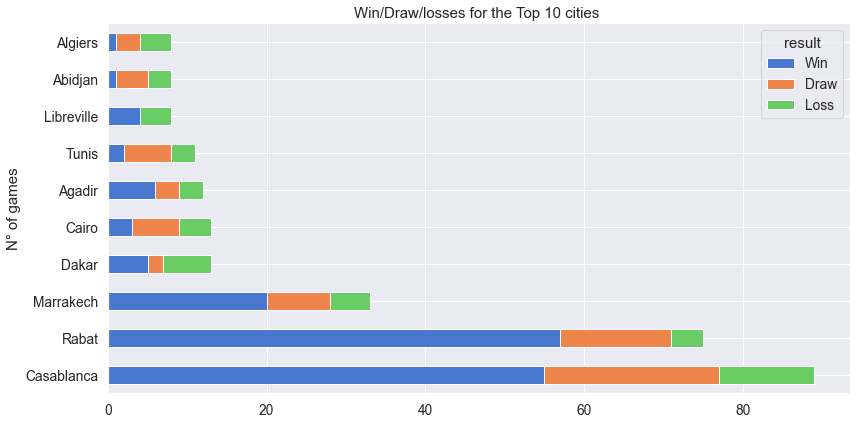

In [48]:
df_result_per_city = df_matches[["city","result"]].groupby("city").value_counts().unstack().fillna(0)
df_result_per_city["Total games"]=df_result_per_city["Draw"]+df_result_per_city["Win"]+df_result_per_city["Loss"]

ax = df_result_per_city.sort_values(by="Total games",ascending=False)[["Win","Draw","Loss"]].head(10)
ax.plot(kind="barh",stacked=True,figsize=(12,6))
plt.title("Win/Draw/losses for the Top 10 cities ")
plt.xticks(rotation=0)
plt.tight_layout()
plt.ylabel("N° of games")


**Plot Highlights :**

- Despite playing more games in casablanca , Morocco has won more in Rabat.
- The other cities in the the TOP 10 are countries that morocco played against the most , Egypt , Algeria , Tunisia and Senegal.
- despite not winning a lot in Tunis , the losses of Morocco there remain less than its wins and Draws combined.
- Morocco Never Drew with Gabon in Libreville , all the games were 50% losses and 50% wins.

## <center>_**Relationship between cities and goals scoring**_</center>

In [49]:
#let's see if there a realtionship between the cities and goals scorred : 

#database to use

df_goals_cities=pd.DataFrame(df_matches["city"])

#Adding a goals scored column : 

goals_scored = []

for i in range(len(df_matches)):
    if df_matches.loc[i,"home_team"] == "Morocco" : 
        goals_scored.append(df_matches.loc[i,"home_score"])
    else :
        goals_scored.append(df_matches.loc[i,"away_score"])

df_goals_cities["scored_goals"] =  goals_scored


<Axes: >

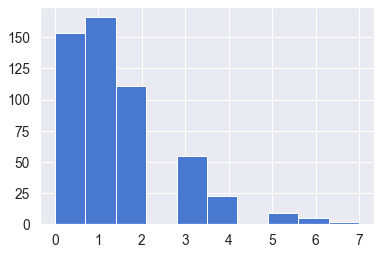

In [50]:
#let's see if the goals scorred variable is normaly distibuted : 
df_goals_cities.scored_goals.hist() 

The variable is not normally distributed so we will use spearman correlation 

In [51]:
# calculating spearman correlation

corr, p_value = stats.spearmanr(df_goals_cities["scored_goals"],df_goals_cities["city"])

print(f"correlation coeff :  {corr}")

print(f"p value : {p_value}")



correlation coeff :  0.12038578733867036
p value : 0.005794006453504124


**Interpretation :** 

Since the p value is less than the 0.05 significance level , we can reject the null hypothesis and say that there is evidence of  monotonic relationhsip between the variables ( even if it's weak). in other terms , Morocco tends to score in some cities more than the others. ( This correlation doesn't mean causation).



## <center>_**Streaks**_</center>

In [52]:
#Stearks ------- Longest winning streak  :

results = df_matches["result"].to_list()

#Using a loop to find all the streaks than finding the max 
Winning_streak = []
Streak = 0
for i , result in enumerate(results) : 
    if result == "Win":
        Streak+=1
        
    else :
        if Streak>1 : 
            Winning_streak.append([i-Streak,i,Streak])
            Streak=0
if Streak > 1 :
    Winning_streak.append([i-Streak,i,Streak])
    
#this loop will render us a list with [the start index of the streak , the end index of the streak ,length of the streak ]
    
# The maximum winning streak :

winning_streak_info = max(Winning_streak , key=lambda element: element[2])

#Formatting printable output :

print(f"Morocco's longest winning streak was an {winning_streak_info[2]}  games serie. It started on {df_matches.date[winning_streak_info[0]].strftime('%m-%Y')} and ended on {df_matches.date[winning_streak_info[1]].strftime('%m-%Y')}.\
The streak Lasted {(df_matches.date[winning_streak_info[1]].year-df_matches.date[winning_streak_info[0]].year)*12 +  df_matches.date[winning_streak_info[1]].month-df_matches.date[winning_streak_info[0]].month} months")


Morocco's longest winning streak was an 11  games serie. It started on 03-2021 and ended on 01-2022.The streak Lasted 10 months


In [53]:
#Stearks ------- Longest losing spree  :
losing_spree = []
Spree = 0
for i , result in enumerate(results) : 
    if result == "Loss":
        Spree+=1
        
    else :
        if Spree>1 : 
            losing_spree.append([i-Spree,i,Spree])
            Spree=0
if Spree > 1 :
    losing_spree.append([i-Spree,i,Spree])
    
#this loop will render us a list with [the start index of the streak , the end index of the streak ,length of the streak ]
    
# The maximum winning streak :

losing_spree_info = max(losing_spree, key=lambda element: element[2])

#Formatting printable output :

print(f"Morocco's longest losing spree was an {losing_spree_info[2]} games serie. It started on {df_matches.date[losing_spree_info[0]].strftime('%m-%Y')} and ended on {df_matches.date[losing_spree_info[1]].strftime('%m-%Y')}.\
The streak Lasted {(df_matches.date[losing_spree_info[1]].year-df_matches.date[losing_spree_info[0]].year)*12 +  df_matches.date[losing_spree_info[1]].month-df_matches.date[losing_spree_info[0]].month} months")



Morocco's longest losing spree was an 5 games serie. It started on 06-1994 and ended on 11-1994.The streak Lasted 5 months


In [54]:
#longest non-losing serie (Wins and Draws ):
Non_losing_serie = []
serie = 0
for i , result in enumerate(results) : 
    if result in ["Draw","Win"]:
        serie+=1
        
    else :
        if serie>1 : 
            Non_losing_serie.append([i-serie,i,serie])
            serie=0
if serie > 1 :
    
    Non_losing_serie.append([i-serie,i,serie])
    
#this loop will render us a list with [the start index of the serie , the end index of the serie ,length of the serie ]
    
# The longest non losing serie  :

Non_losing_serie_info = max(Non_losing_serie, key=lambda element: element[2])

#Formatting printable output :

print(f"Morocco's longest non losing serie was an {Non_losing_serie_info[2]} games serie." 
      f"It started on {df_matches.date[Non_losing_serie_info[0]].strftime('%m-%Y')} and ended on {df_matches.date[Non_losing_serie_info[1]].strftime('%m-%Y')}."
    f"The streak Lasted {(df_matches.date[Non_losing_serie_info[1]].year-df_matches.date[Non_losing_serie_info[0]].year)*12 +  df_matches.date[Non_losing_serie_info[1]].month-df_matches.date[Non_losing_serie_info[0]].month} months")


Morocco's longest non losing serie was an 18 games serie.It started on 11-2019 and ended on 01-2022.The streak Lasted 26 months


In [55]:
#longest non-winning serie (losses and Draws):
non_winning_serie = []
serie = 0

for i, result in enumerate(results):
    if result in ["Draw", "Loss"]:
        serie += 1
    else:
        if serie > 1:
            non_winning_serie.append([i - serie, i, serie])
            serie = 0

if serie > 1:
    non_winning_serie.append([i - serie, i, serie])

# The longest non-winning serie:
non_winning_serie_info = max(non_winning_serie, key=lambda element: element[2])

# Formatting printable output:
print(f"Morocco's longest non-winning serie was an {non_winning_serie_info[2]} games serie. "
      f"It started on {df_matches.date[non_winning_serie_info[0]].strftime('%m-%Y')} "
      f"and ended on {df_matches.date[non_winning_serie_info[1]].strftime('%m-%Y')}. "
      f"The streak lasted {((month_difference := (df_matches.date[non_winning_serie_info[1]].year - df_matches.date[non_winning_serie_info[0]].year) * 12 +df_matches.date[non_winning_serie_info[1]].month - df_matches.date[non_winning_serie_info[0]].month + 1))} months")



Morocco's longest non-winning serie was an 8 games serie. It started on 03-1994 and ended on 11-1994. The streak lasted 9 months


## <center>_**A binary betting patterns simulation**_</center>

This Part of the project will focus on simulating and studying winrates of different betting patterns.

In [56]:
#let's get the data we wiill need in our betting patterns 

df_betting = df_matches[["date","home_team","away_team","home_score","away_score","result"]]


In [ ]:
df_betting.head(20)

In order to etablish our betting patterns  we need to define our main variables :
1. Bet type : the bet type means if the bettor is betting on the result ( Win/loss) or the score ( Scoring over/under a certain amount of goal).since our goal is to study binnary betting patterns we made sure to pick scenarios with only 2 options.
2. Initial bet : stands for the first bet that the bettor will place and it can be "win" or "loss" in the case of a bet on result and it can be "over" or "under"in the case of a bet on "Score".
3. Betting behavior 1 : and refers to the pattern that the bettor uses to places his bets. and it can be either " Changing bets after a win " (CBAW) or "Changing bets after a loss" (CBAL). In the CBAW case , after every winning bet , the next bet is opposite to it , and in the case of CBAW , after each winning bet , the next bet is the same and the bettor only cahnges his bet after a losing bet .
4. Betting behavior 2 : and refers to the pattern that the bettor uses to calculate the betting amout to place , and it can be either a " fixed betting amount" FBA , " Doubling Down on wins " (DDW) or "Chasing losses "(CL). in the FBA case , the bettor places the same amout on every bet. In the the DDW case , the bettor doubles his betting amount after each win and resets it to the ititial betting amount after a loss , and lastly for the CL case , the bettor doubles the betting amount after each loss and resets it to the ititial betting amount after a win.

Using the combination of the different variable we can come up with 24 differenet scenarios as shown bellow , that we simulate a million time for each scenario and analyse.

NB : 

In the case of a bet on result , a draw is a win for both bets. 

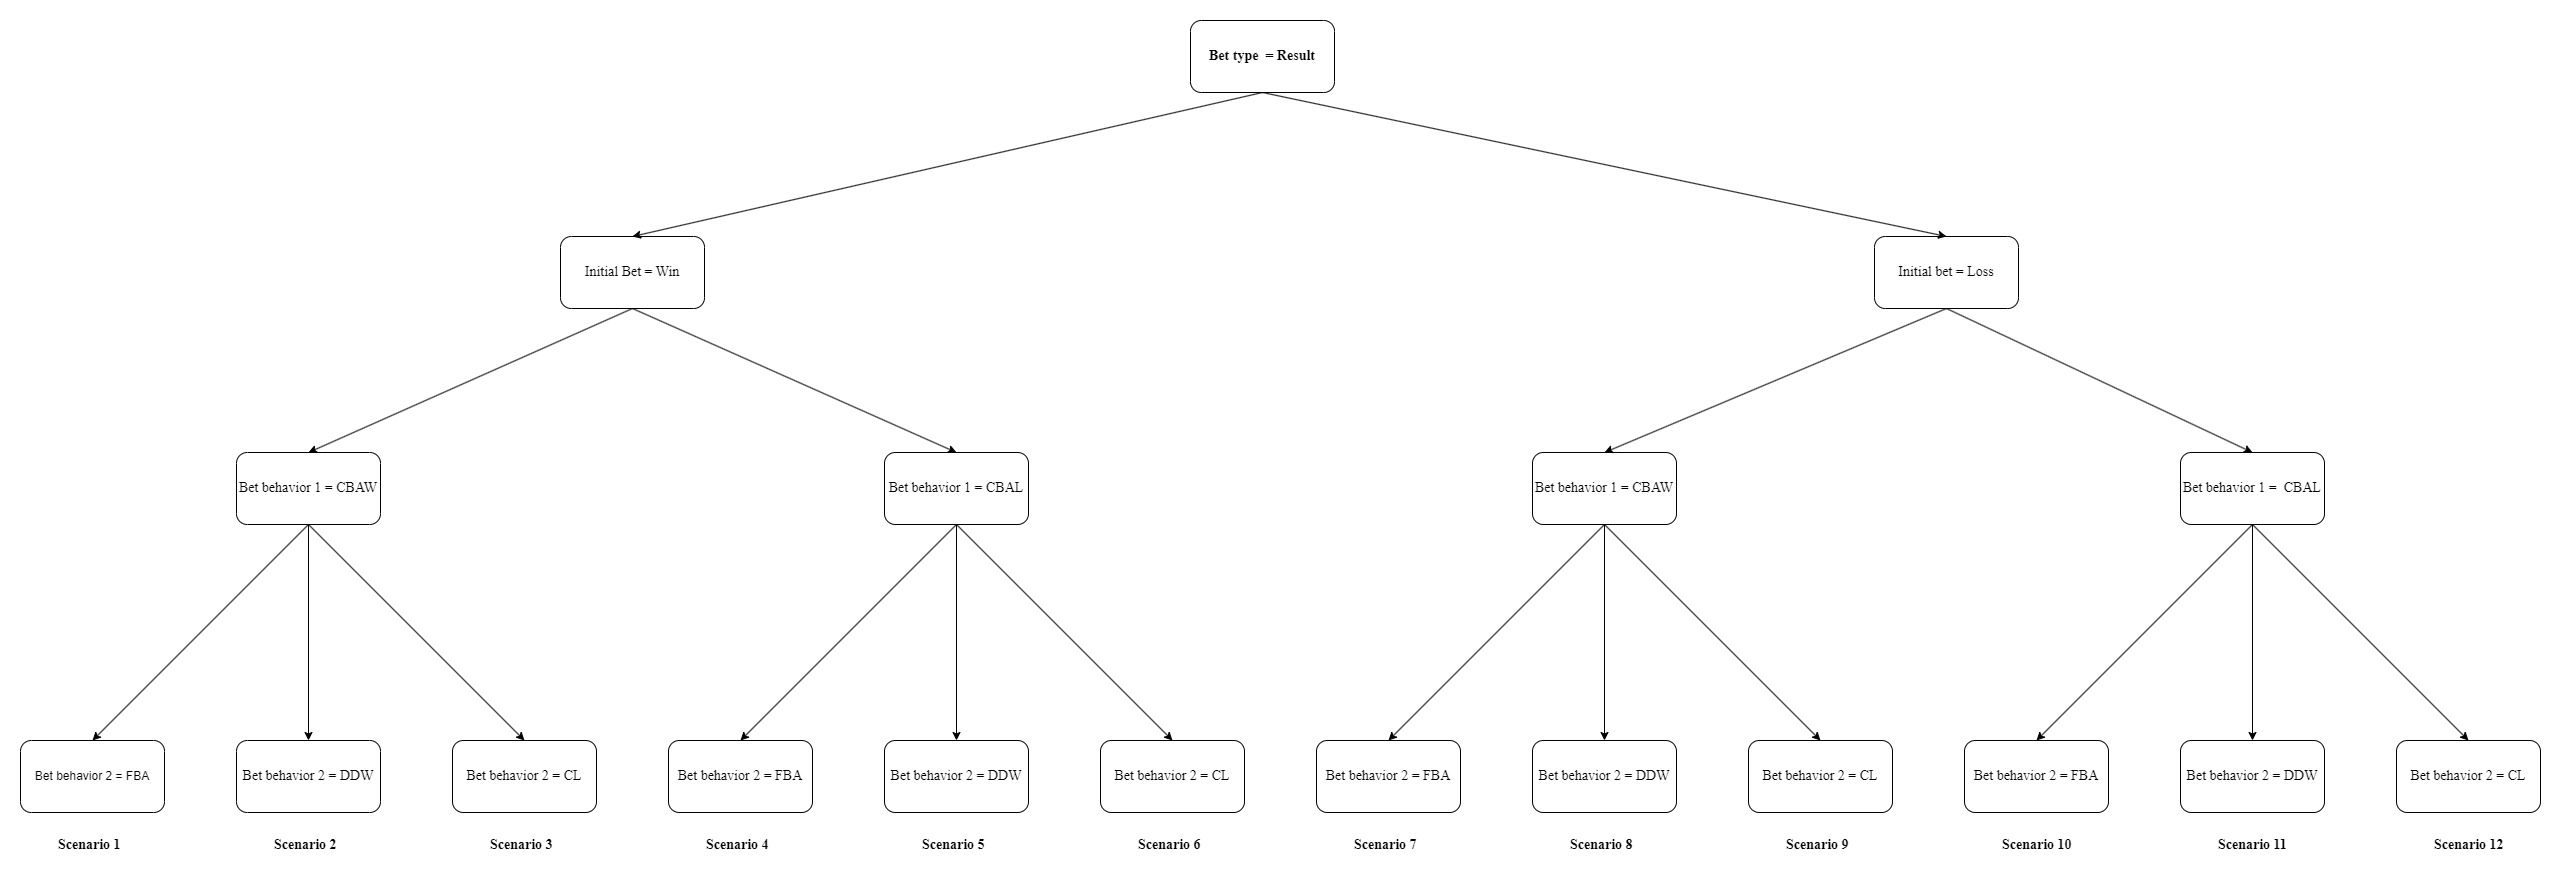

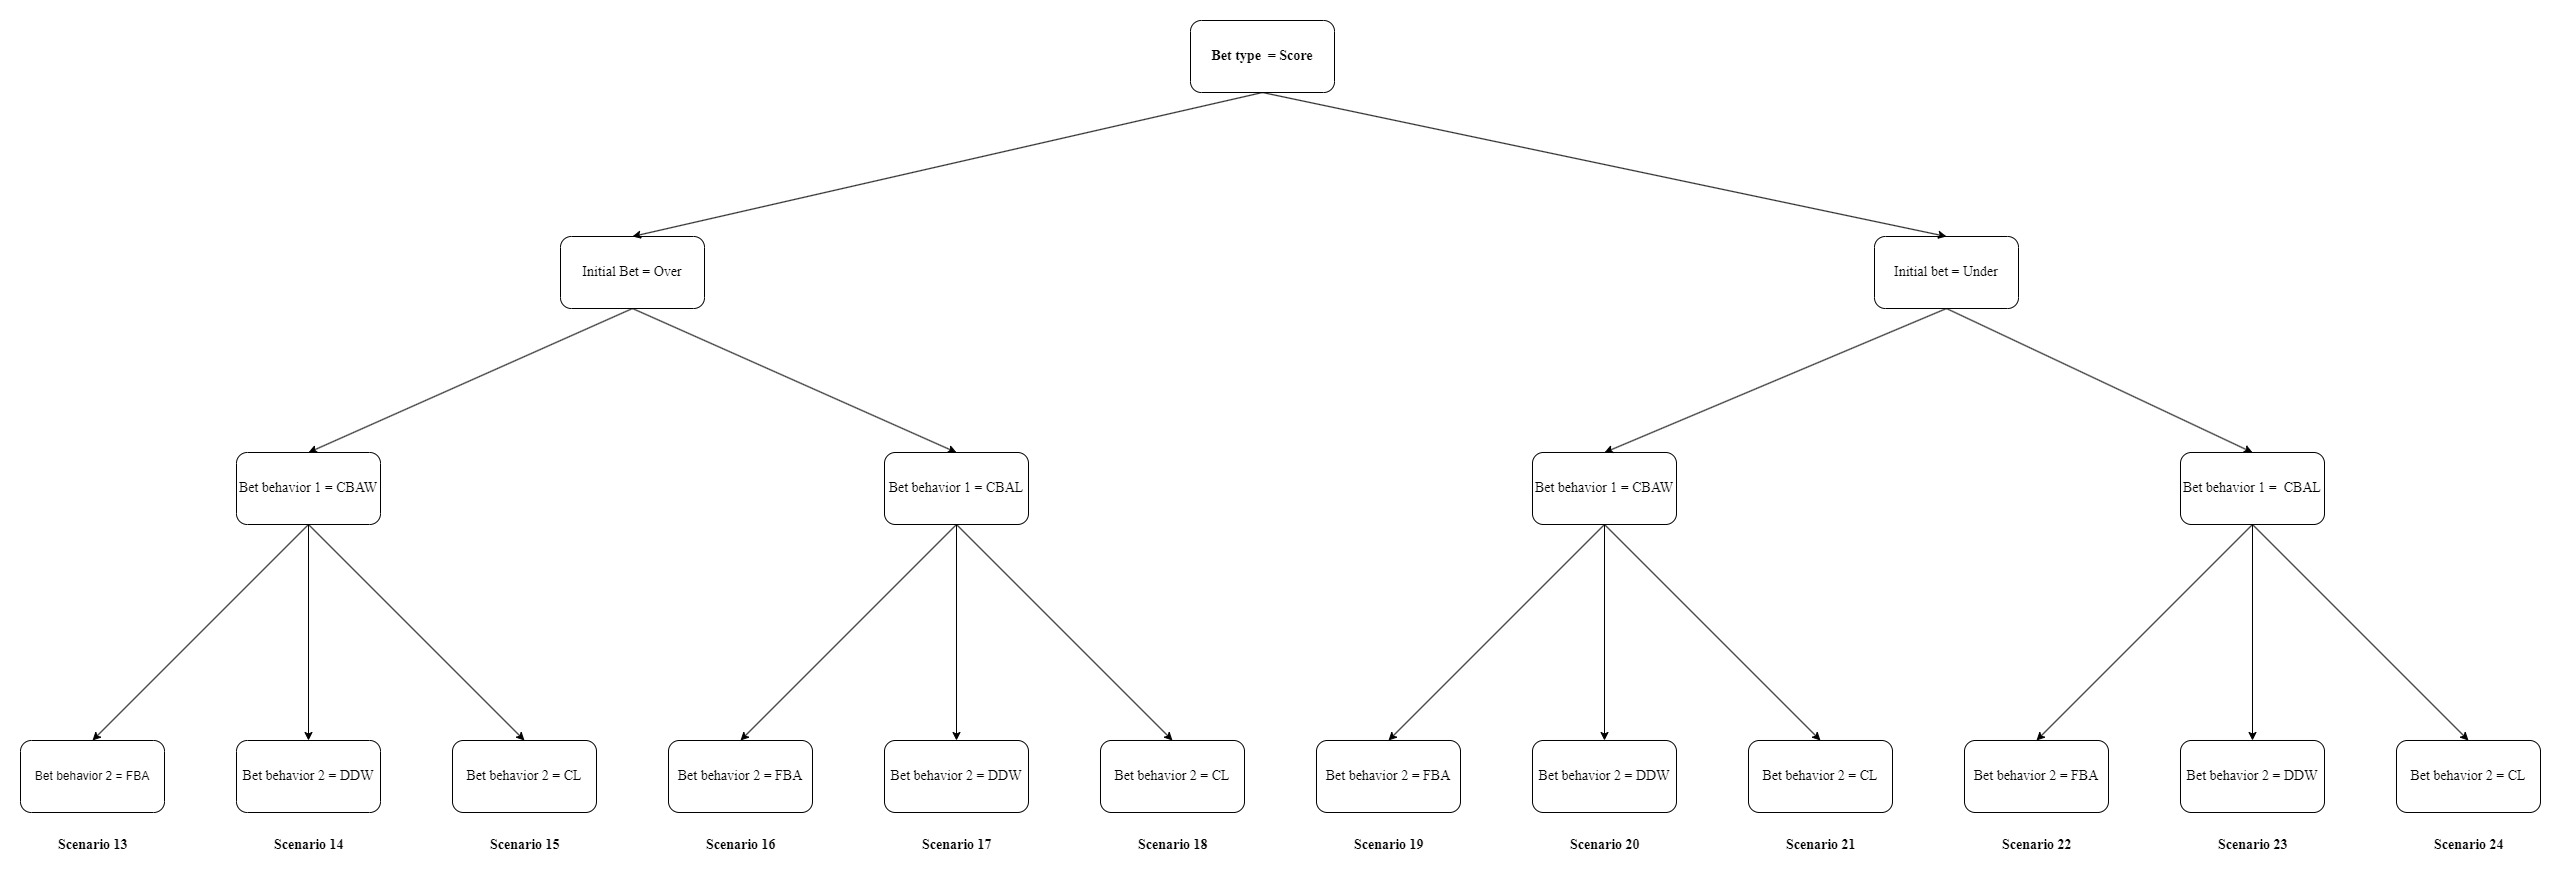

In [59]:
#Betting_behavior_1 = [CBAW,CBAL]
#Betting_behavior_2 = [FBA,DDW,CL]
#Bet_type = ["Result","Score"]
#initialbet = ["Win","Loss","Over","Under"]

#defining a function that return the betting results and the max win streak


def Betting_results(Bet_type,initial_bet,Betting_behavior_1,goals=0) :
    
    Result_opposite={"Win":"Loss","Loss":"Win"}
    
    Score_opposite={"Over":"Under","Under":"Over"}
   
    Current_bet=initial_bet 
    
    betting_results = np.zeros(len(df_betting),np.int64)
    
    for i in range (len(df_betting)) : 
        if Bet_type == "result" : 
            if Betting_behavior_1 =="CBAW":
                if df_betting.loc[i,"result"] in [Current_bet,"Draw"] :
                    betting_results[i]=1
                    Current_bet=Result_opposite[Current_bet]
                else :
                    betting_results[i]= 0       
            elif Betting_behavior_1 =="CBAL":
                if df_betting.loc[i,"result"] in [Current_bet,"Draw"] :
                    betting_results[i]=1
                else :
                    betting_results[i]= 0 
                    Current_bet=Result_opposite[Current_bet]
        elif Bet_type=="Score":
            if Betting_behavior_1 =="CBAW":
                if df_betting.loc[i,"home_team"]=="Morocco":
                    if ( df_betting.loc[i,"home_score"]> (float(goals)-0.5) and Current_bet == "Over" ) or \
                        (df_betting.loc[i,"home_score"]< (float(goals)-0.5) and Current_bet == "Under") : 
                        betting_results[i]=1
                        Current_bet=Score_opposite[Current_bet]
                    else  :
                        betting_results[i]=0
                else:
                    if ( df_betting.loc[i,"away_score"]> (float(goals)-0.5) and Current_bet == "Over" ) or \
                        (df_betting.loc[i,"away_score"]< (float(goals)-0.5) and Current_bet == "Under") : 
                        betting_results[i]=1
                        Current_bet=Score_opposite[Current_bet]
                    else  :
                        betting_results[i]=0
            elif Betting_behavior_1 == "CBAL":
                if df_betting.loc[i,"home_team"]=="Morocco":
                    if ( df_betting.loc[i,"home_score"]> (float(goals)-0.5) and Current_bet == "Over" ) or \
                        (df_betting.loc[i,"home_score"]< (float(goals)-0.5) and Current_bet == "Under") : 
                        betting_results[i]=1
                        
                    else  :
                        betting_results[i]=0
                        Current_bet=Score_opposite[Current_bet]
                else:
                    if ( df_betting.loc[i,"away_score"]> (float(goals)-0.5) and Current_bet == "Over" ) or \
                        (df_betting.loc[i,"away_score"]< (float(goals)-0.5) and Current_bet == "Under") : 
                        betting_results[i]=1
                        
                    else  :
                        betting_results[i]=0
                        Current_bet=Score_opposite[Current_bet]
    win_streak=1
    max_streak=1            
    for i in range(1, len(betting_results)):
        
        if betting_results[i] == betting_results[i - 1]:
            
            win_streak += 1
        else:
            win_streak = 1

        max_streak = max(max_streak, win_streak)            
    
    return betting_results,max_streak
#---------------------------------------------------------------------------------------------#
# defining a function that calculates betting  Amounts 
def Betting_amounts(Bet_type,initial_bet, Betting_behavior_1,Betting_behavior_2,initial_betting_amount=300,goals=3):
    
    betting_results,longest_streak= Betting_results(Bet_type,initial_bet, Betting_behavior_1, goals)
    
    Bets_amount = np.full(len(betting_results),initial_betting_amount,np.int64)
    
    for i in range(1, len(betting_results)):
        
        if Betting_behavior_2 == "DDW":
            
            if betting_results[i - 1] == 1:
                
                Bets_amount[i] = Bets_amount[i - 1]*2
                
            else:
                Bets_amount[i] = initial_betting_amount
                
        elif Betting_behavior_2 == "CL":
            
            if betting_results[i - 1] == 1:
                
                Bets_amount[i] = initial_betting_amount
            else:
                
                Bets_amount[i] = Bets_amount[i - 1]*2
                
        elif Betting_behavior_2 =="FBA":
            
            Bets_amount = np.full(len(betting_results),initial_betting_amount,np.int64)
            
    return np.sum(Bets_amount),Bets_amount,betting_results,longest_streak
#------------------------------------------------------------------------#

#defining a simulation function that simulates and returns the simulations results and plots them

def results_simulation(Bet_type, initial_bet, Betting_behavior_1, Betting_behavior_2, goals=3, n_sim=100, min_odd=1.5, max_odd=2.5, step=0.1,initial_betting_amount=100):

    total_bets, bets_amount,betting_results,longest_streak = Betting_amounts(Bet_type,initial_bet, Betting_behavior_1,Betting_behavior_2,initial_betting_amount,goals=3)
    
   
    odds_range=np.arange(min_odd,max_odd,step).round(2)
    pnl=np.zeros(len(betting_results),np.int64)
    simulation_results = np.zeros(n_sim,np.int64)
    for i in range (n_sim):
        generated_odds=np.random.choice(odds_range,len(betting_results),replace=True)
        pnl=[(odd-1)*bet_amount if bet_result==1 else  - bet_amount for odd,bet_result,bet_amount in zip(generated_odds,betting_results,bets_amount)]
        simulation_results[i] = np.sum(pnl).round()
        
    #plotting :
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7))
    plt.suptitle(f'Startegy : {Bet_type,initial_bet,Betting_behavior_1,Betting_behavior_2}', fontsize=16, y=0.95)
    
    # Plotting Betting Results 
    pd.DataFrame(betting_results).value_counts().sort_index().plot(kind="bar",ax=ax1,color=["red","green"])
    ax1.set_xticklabels(["Bet lost","Bet won"],rotation=0)
    ax1.set_title('Bets won/Bets Lost ')
    ax1.set_xlabel('')
    ax1.set_ylabel('Bet result')
    
    # Plotting winrate 
    ax2.pie([np.sum(betting_results == 0), np.sum(betting_results == 1)], labels=['Loss', 'Win'], autopct='%1.1f%%', colors=['red', 'green'],wedgeprops=dict(width=0.3, edgecolor='black'))
    ax2.set_title("Strategy winrate")

    # Plotting Simulation Results as Histogram
    sns.histplot(simulation_results, bins=20, kde=True, color='blue', ax=ax3)
    ax3.set_title('Simulated Profits and losses')
    ax3.set_xlabel('Pnl')
    ax3.set_ylabel('Frequency')
    
    #adding some key metrics on the figure :
    
    ax4 = plt.axes([0, 0, 1, 0.1], frame_on=False)
    ax4.set_xticks([])
    ax4.set_yticks([])

    # Display statistics
    ax4.text(0.5, 1.0, f"Strategie Winrate: {((np.sum(betting_results == 1)/(np.sum(betting_results == 1)+np.sum(betting_results == 0)))*100).round(2)}%", ha='center', va='center', fontsize=14, color='black')
    ax4.text(0.5, 0.7, f"Average Simulated PnL: {np.mean(simulation_results).round(2):,} MAD", ha='center', va='center', fontsize=14, color='black')
    ax4.text(0.5, 0.4, f"Maximum Simulated PnL: {np.max(simulation_results):,} MAD", ha='center', va='center', fontsize=14, color='black')
    ax4.text(0.5, 0.1, f"Minimum Simulated PnL: {np.min(simulation_results):,} MAD", ha='center', va='center', fontsize=14, color='black')
    ax4.text(0.5, -0.2, f"Longest_win_streak: {longest_streak} wins ", ha='center', va='center', fontsize=14, color='black')
    ax4.text(0.5, -0.5, f"Biggest bet placed: {np.max(bets_amount):,} MAD", ha='center', va='center', fontsize=14, color='black')
    
    

    
    
    plt.tight_layout()
        

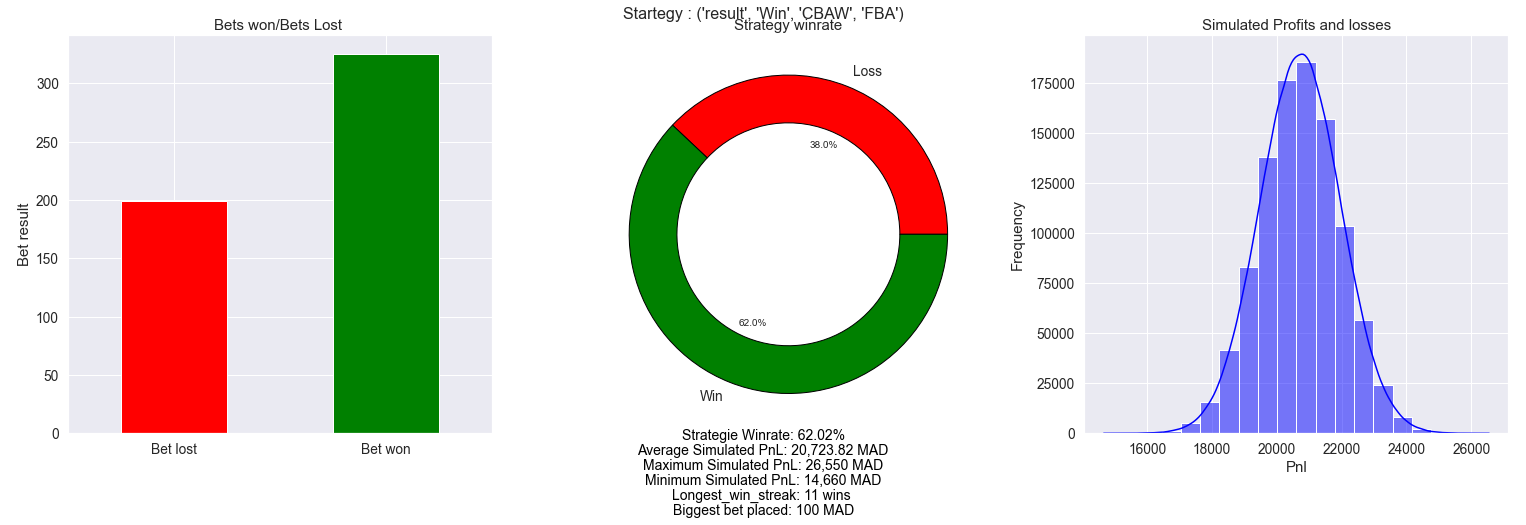

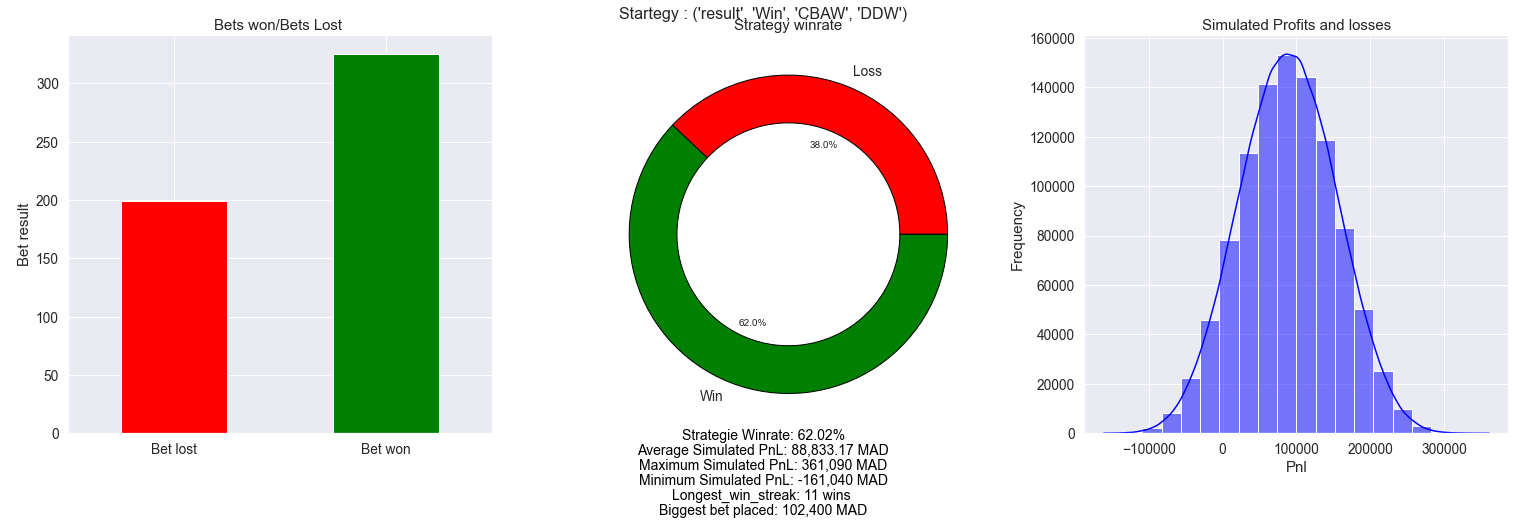

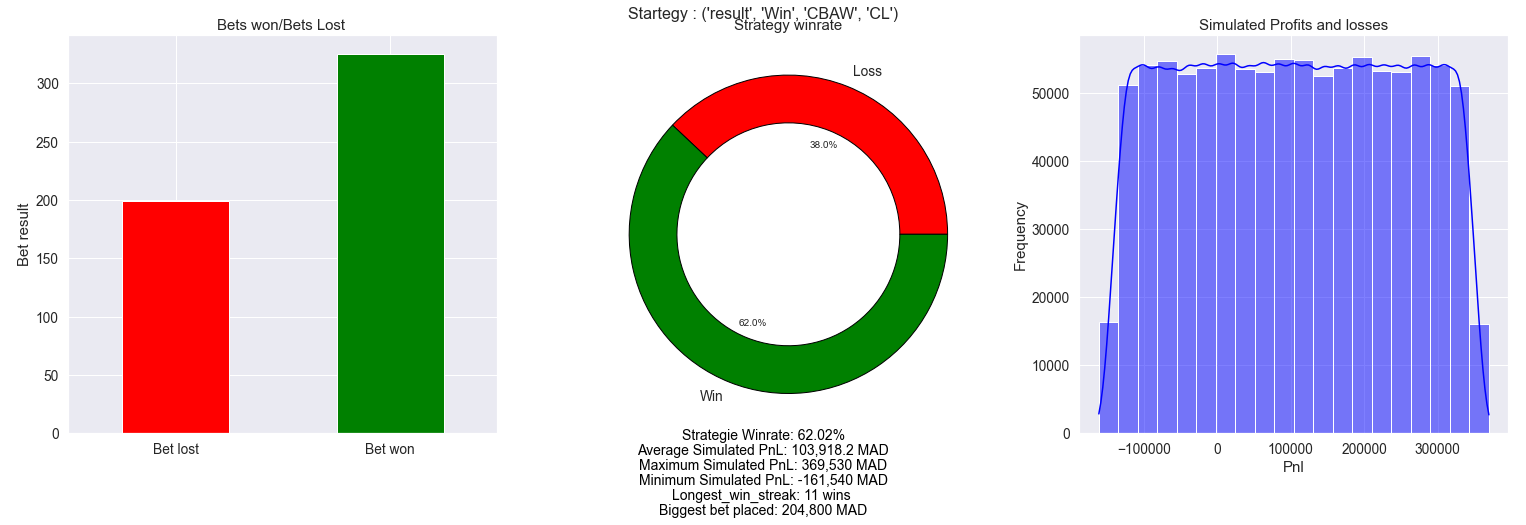

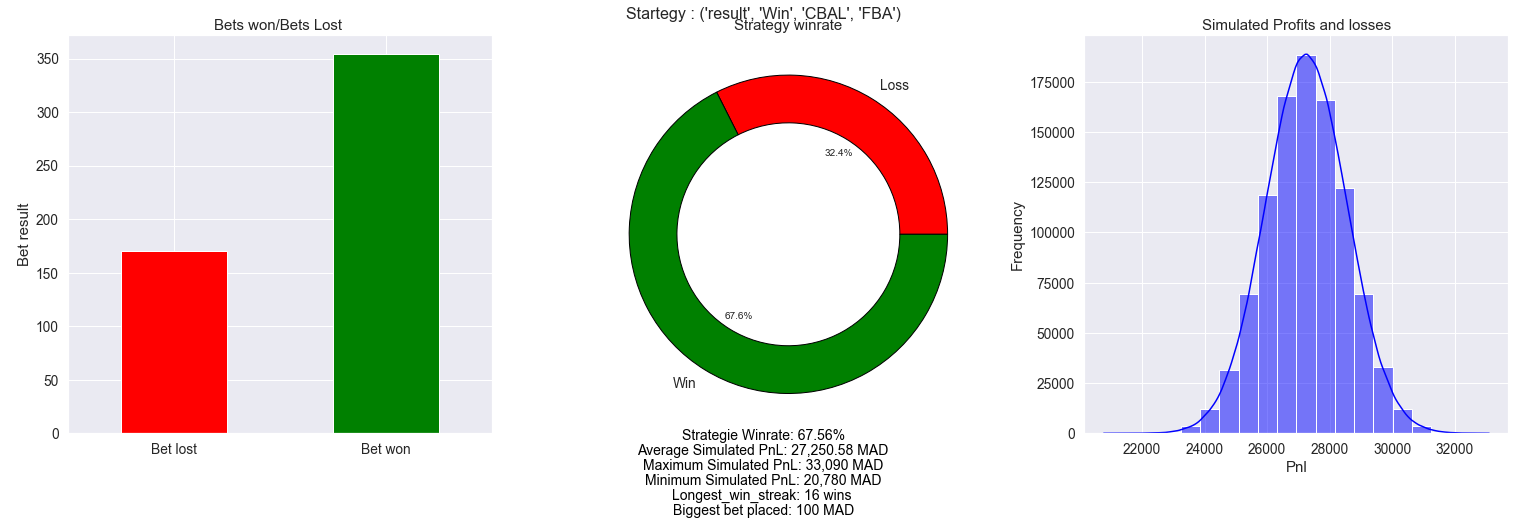

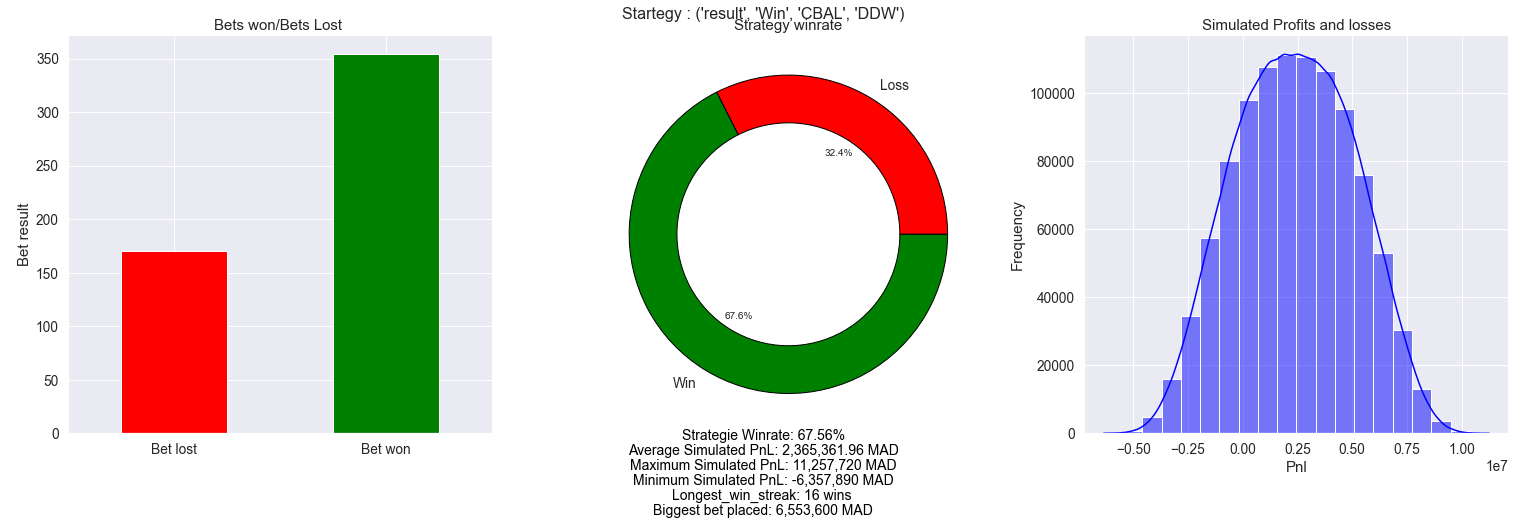

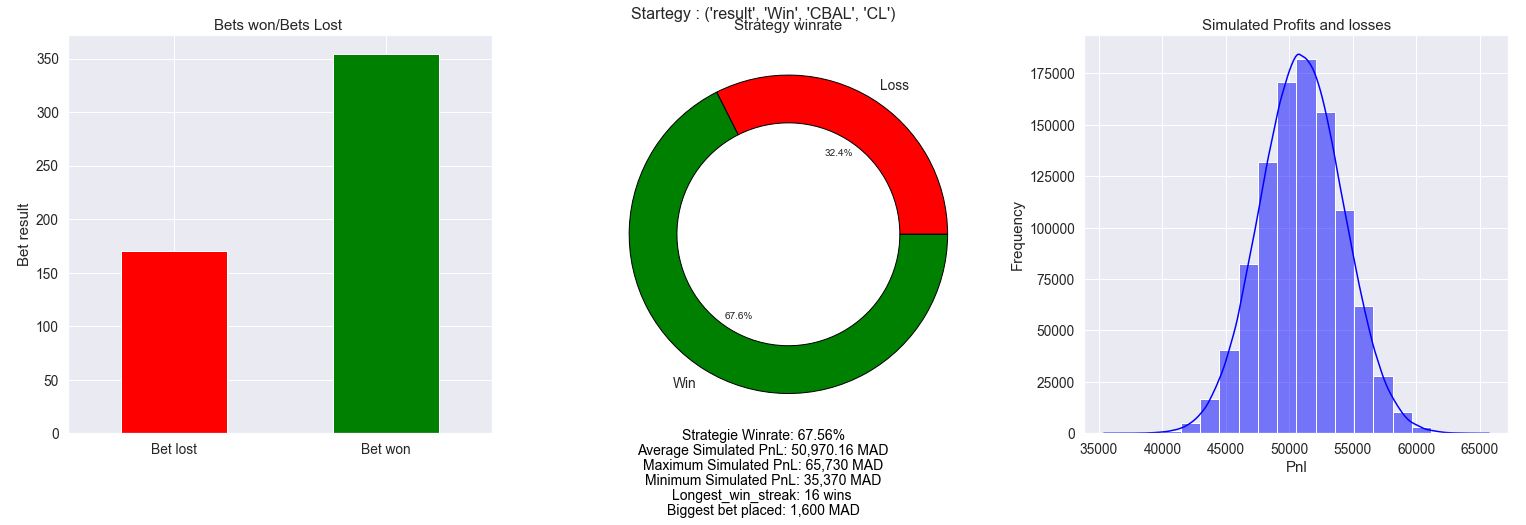

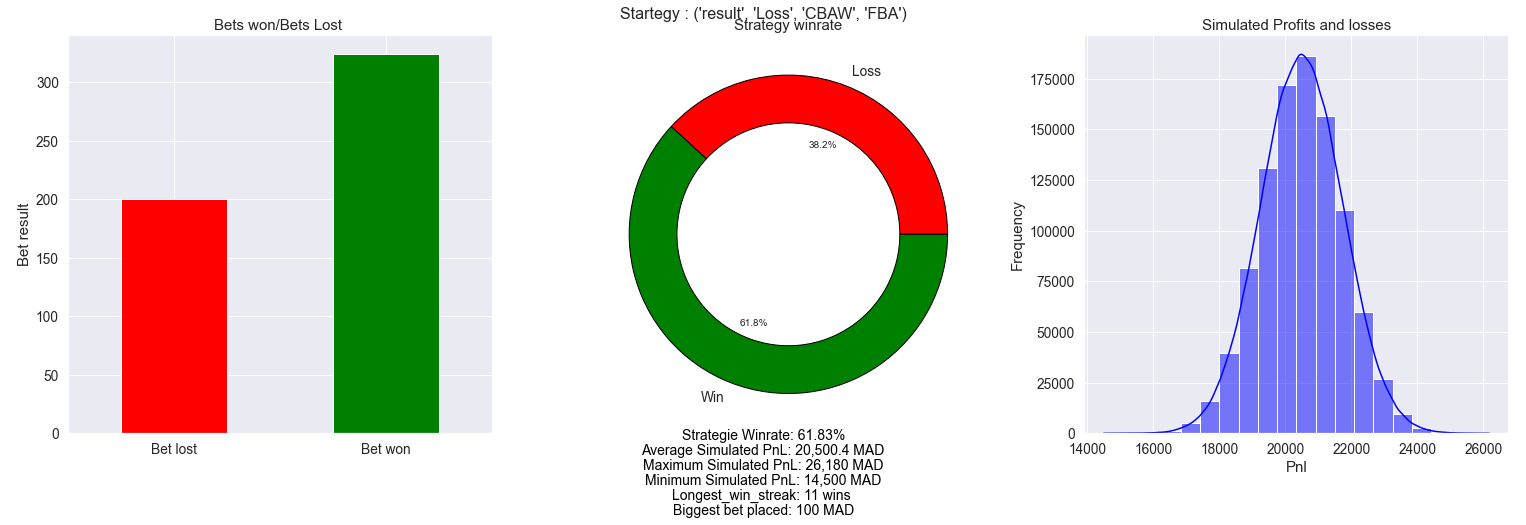

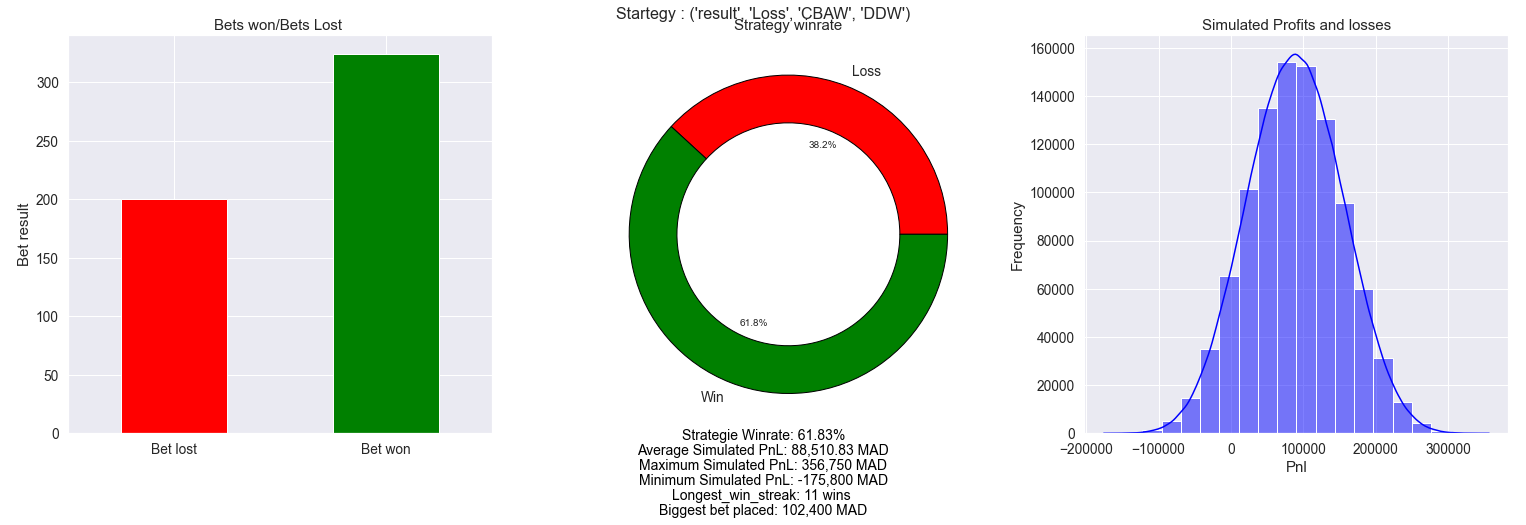

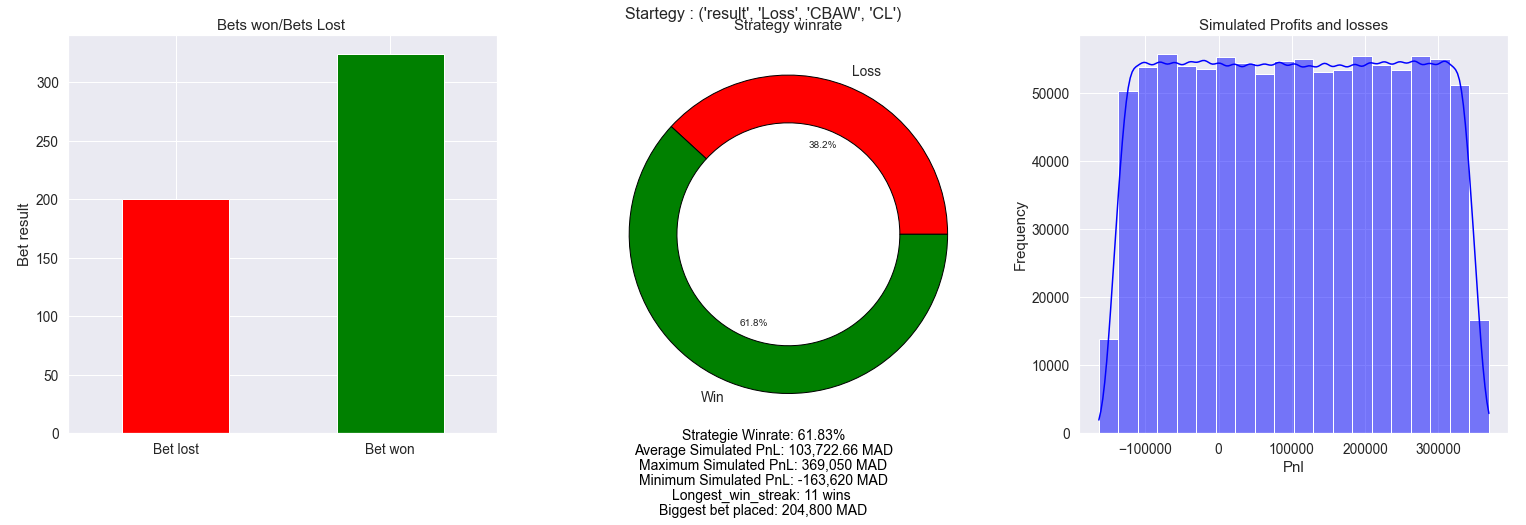

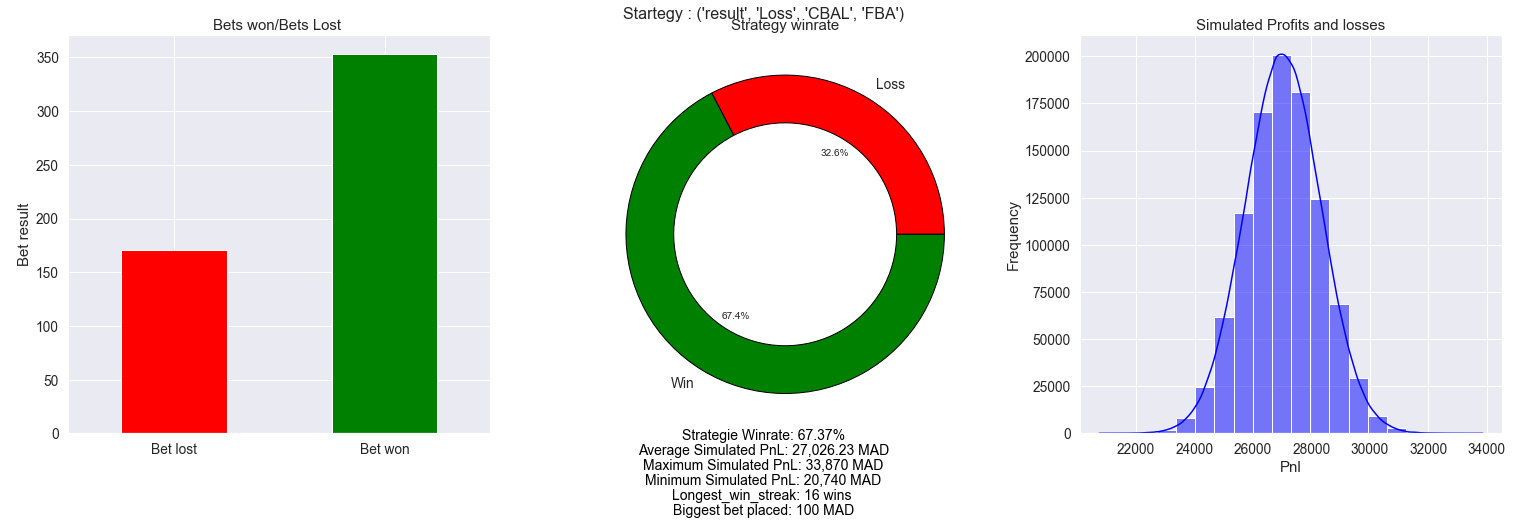

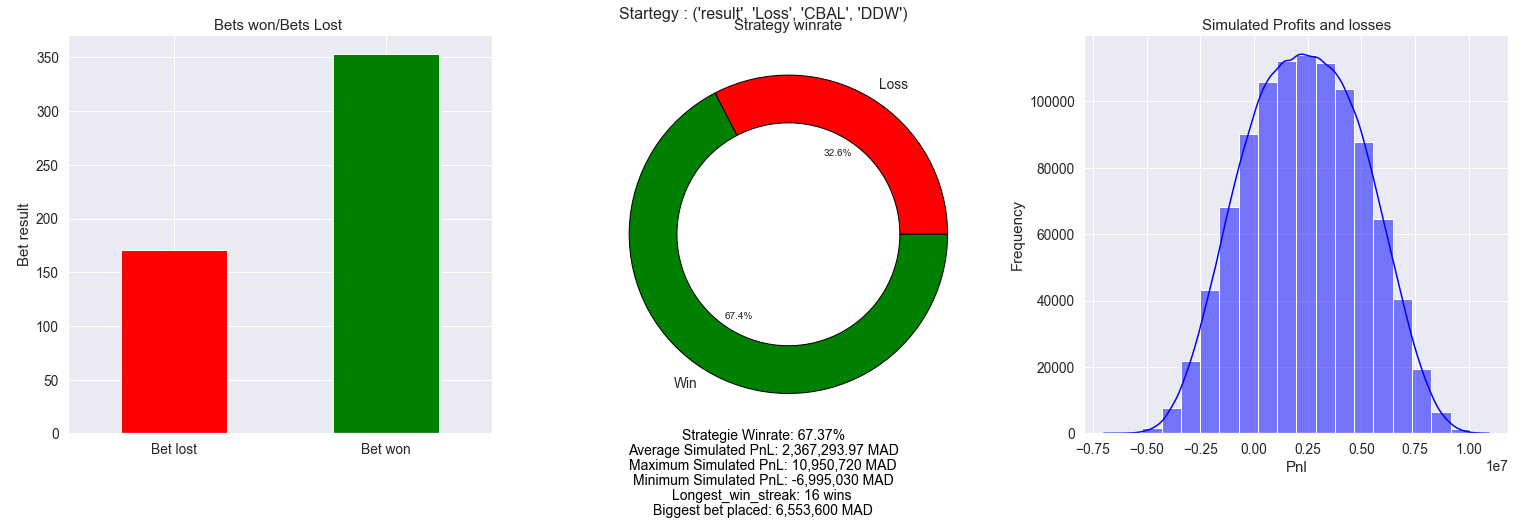

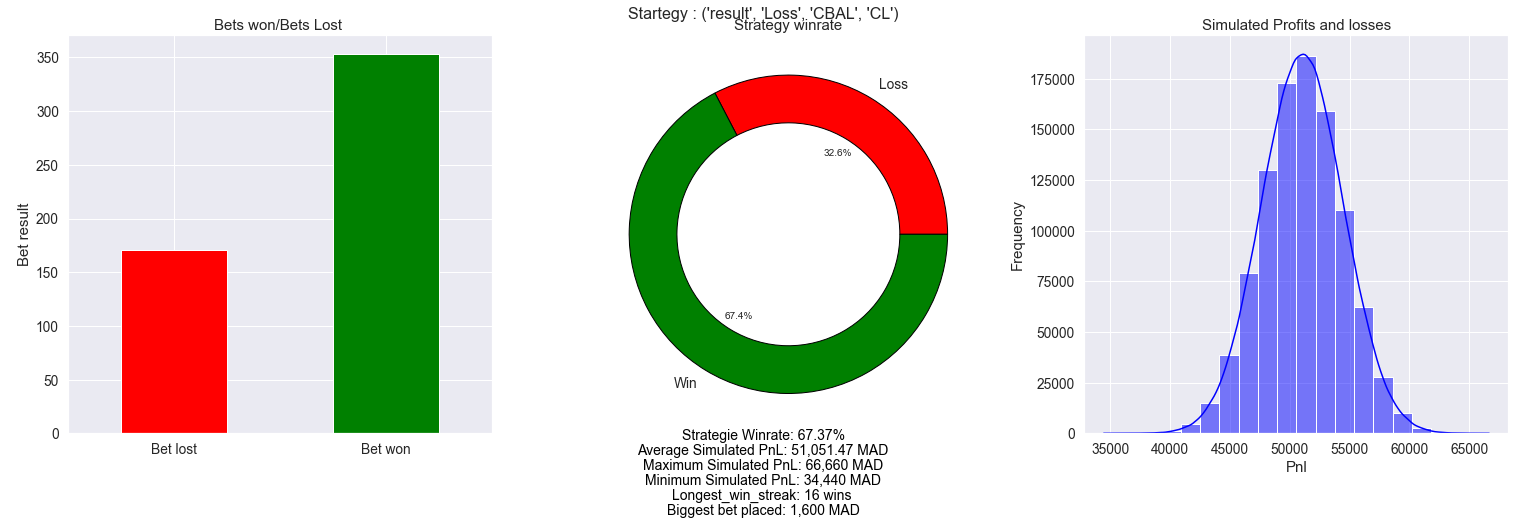

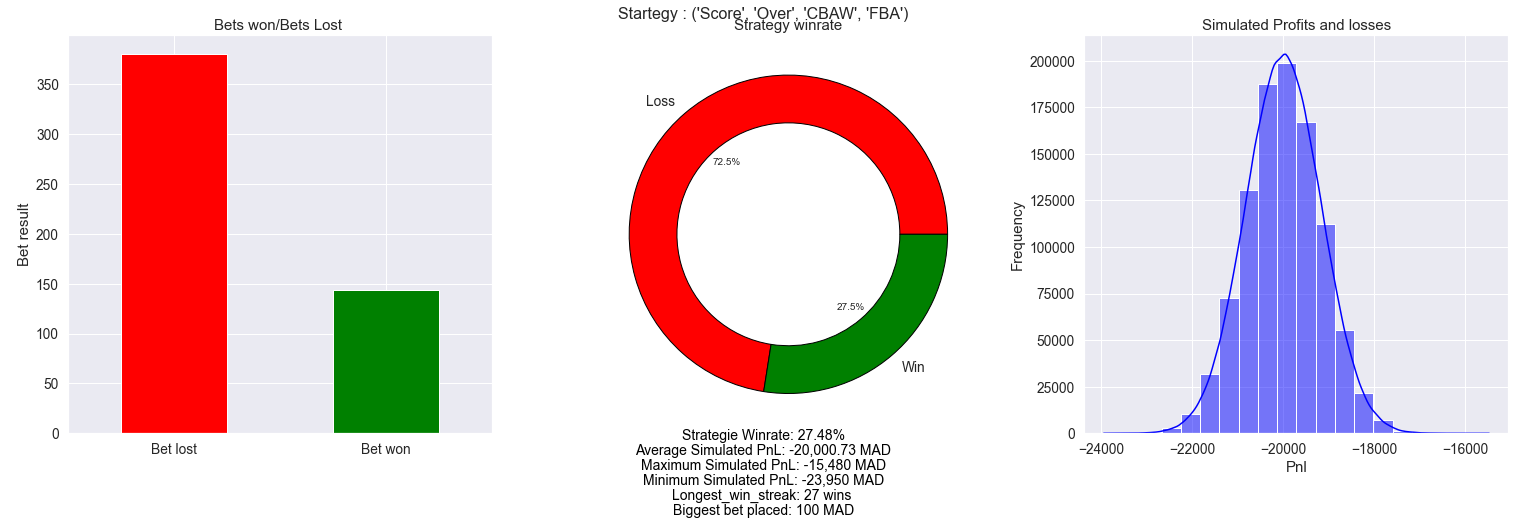

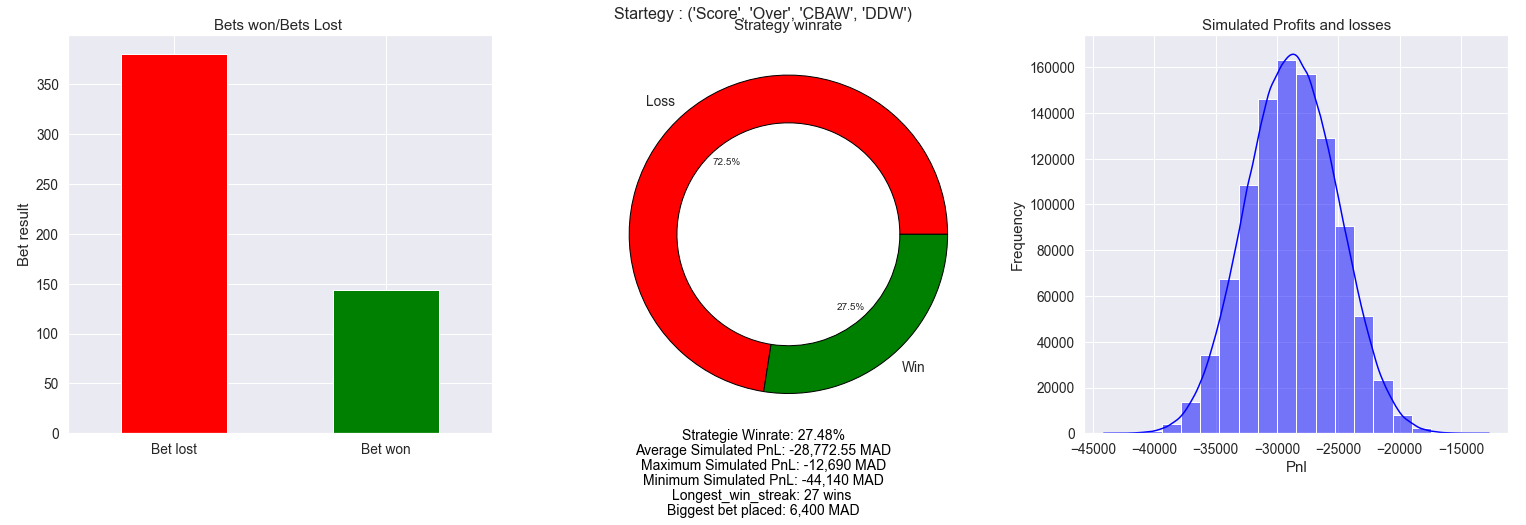

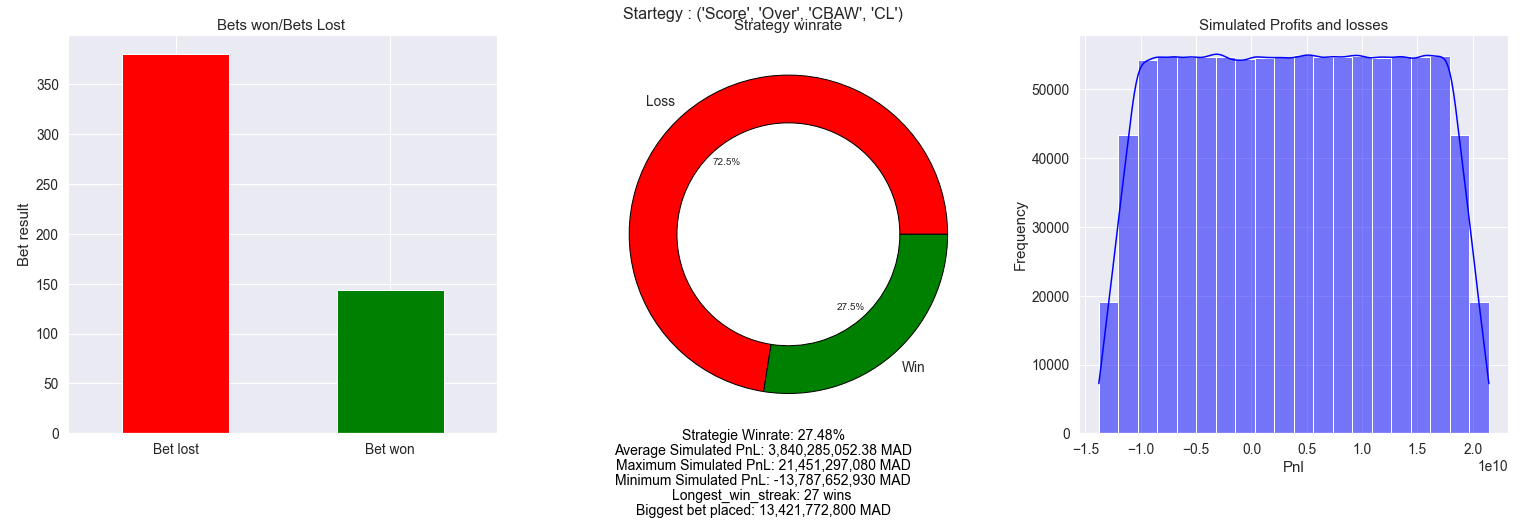

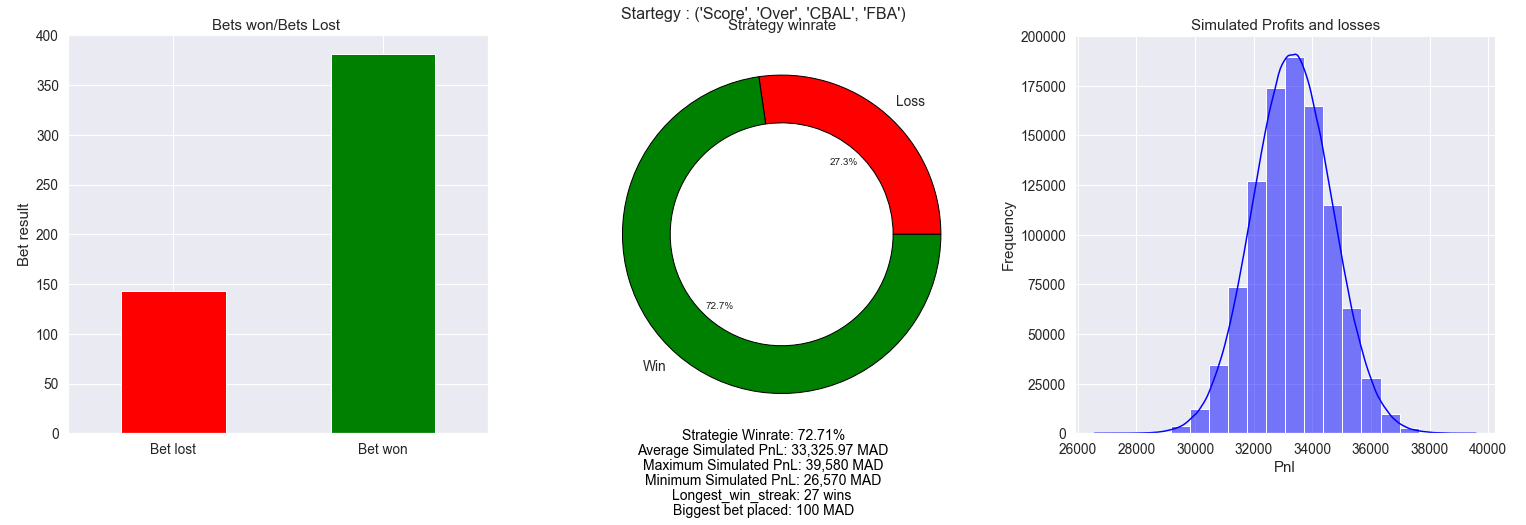

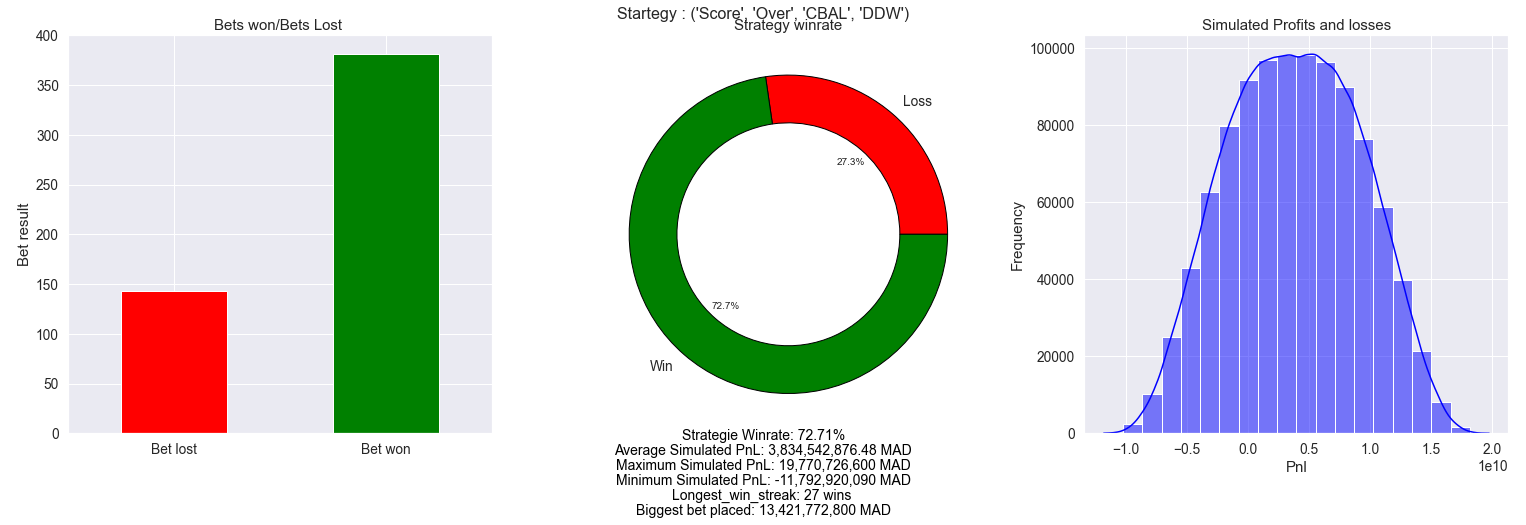

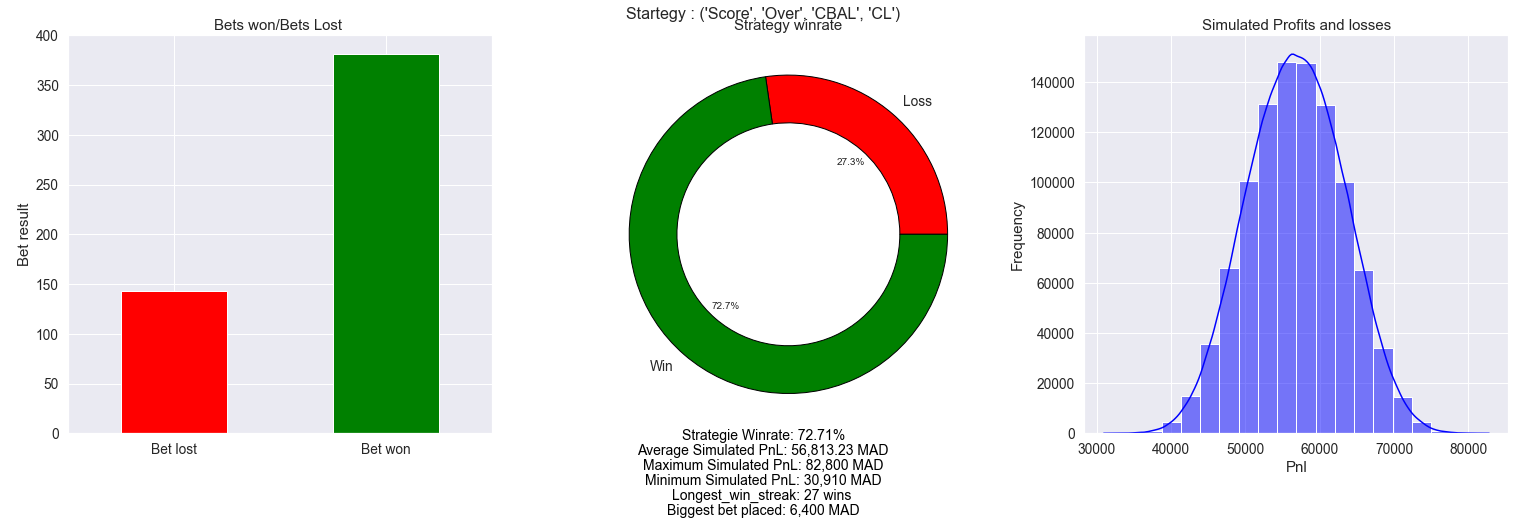

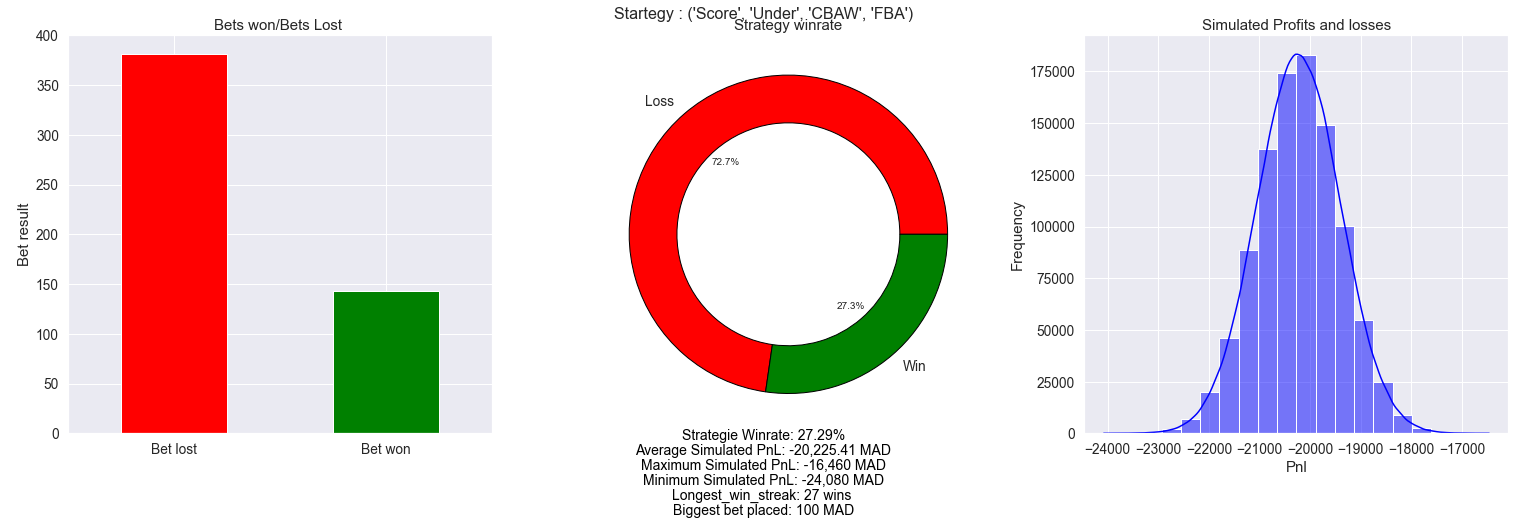

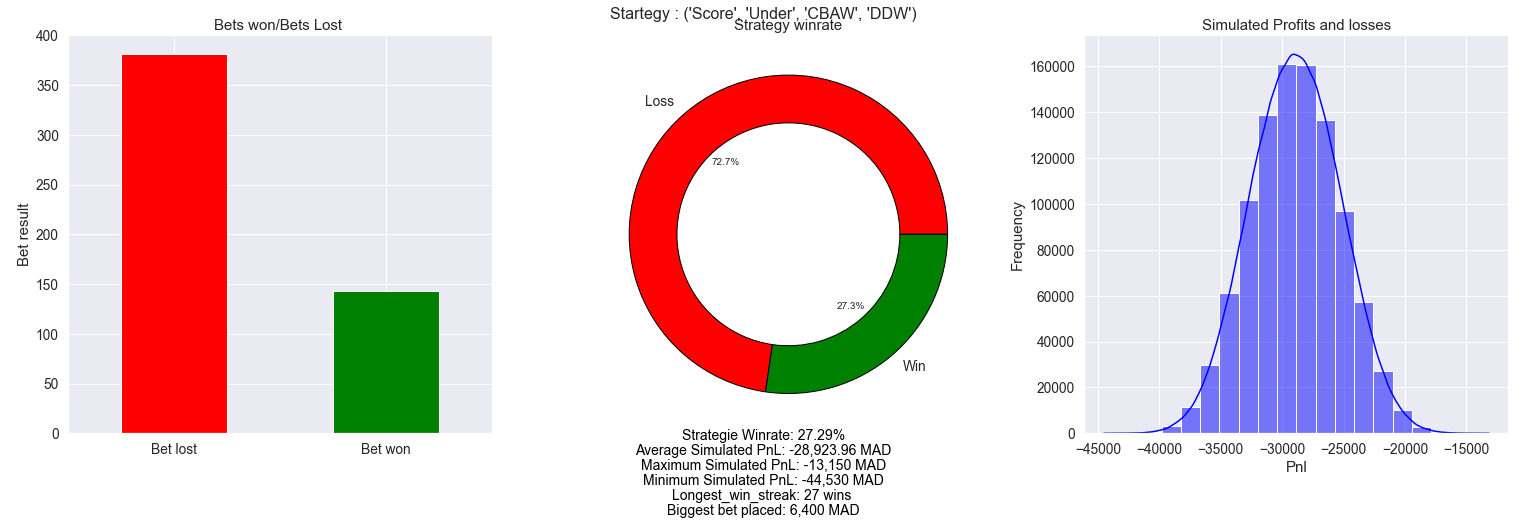

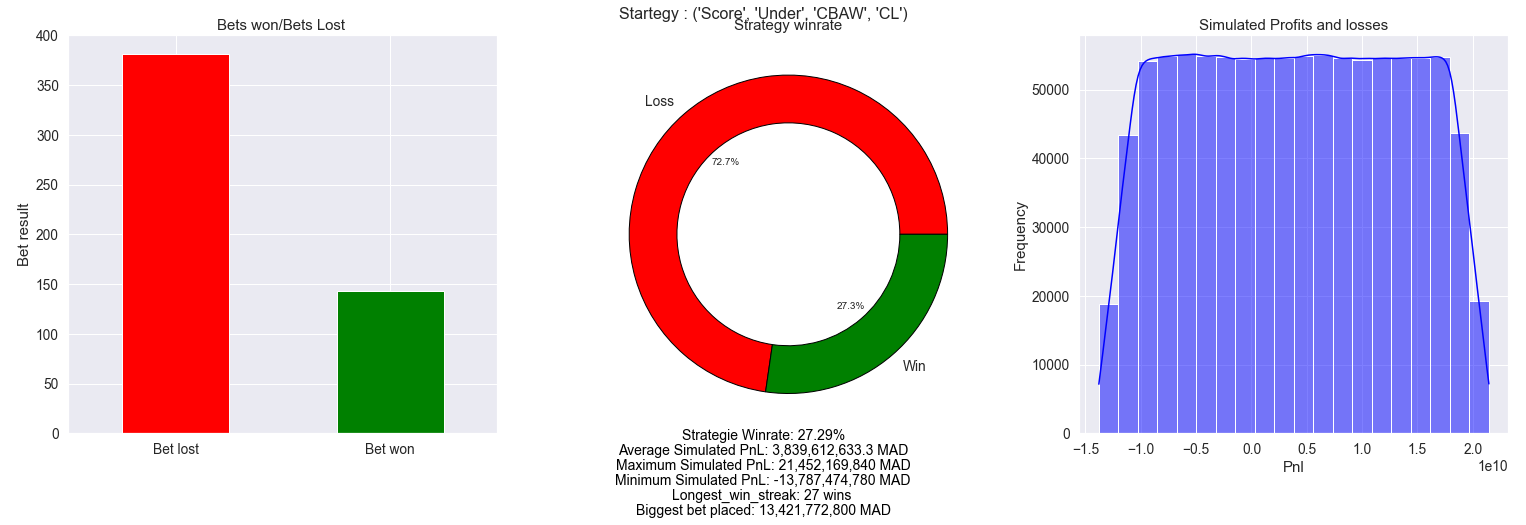

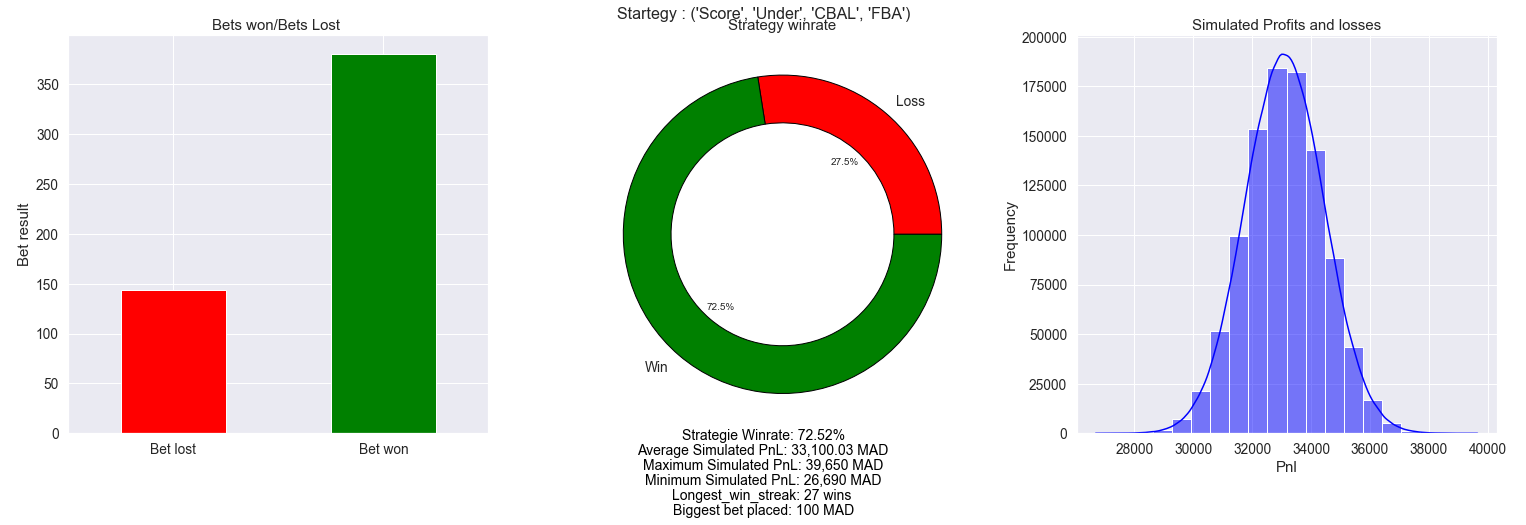

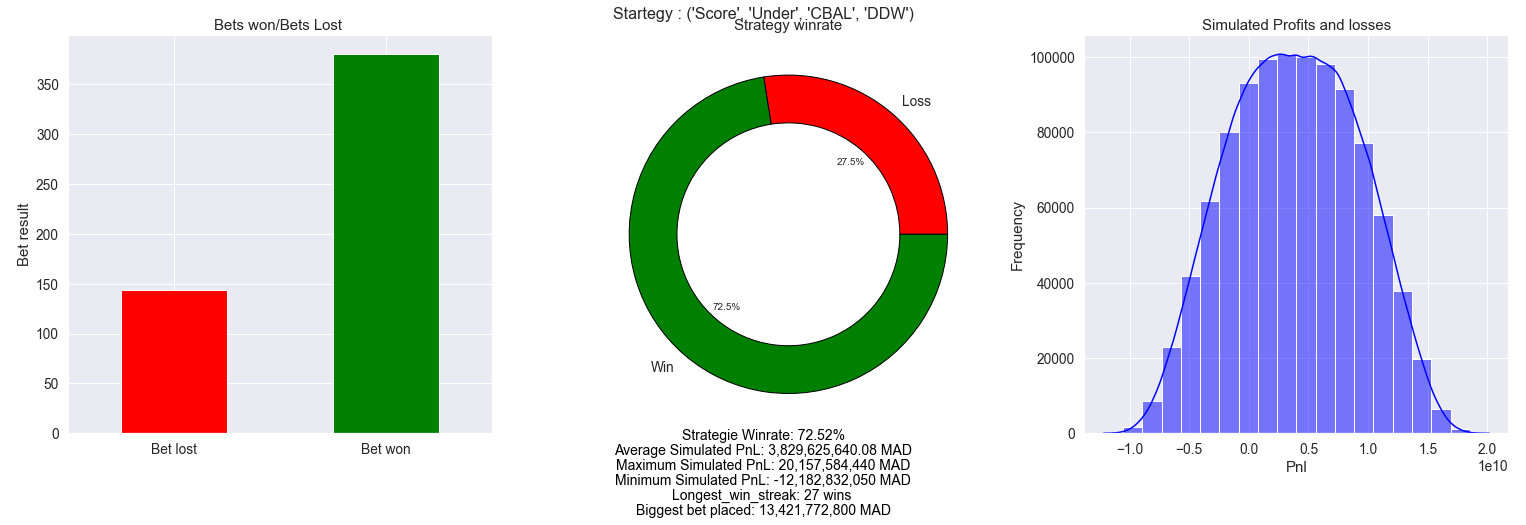

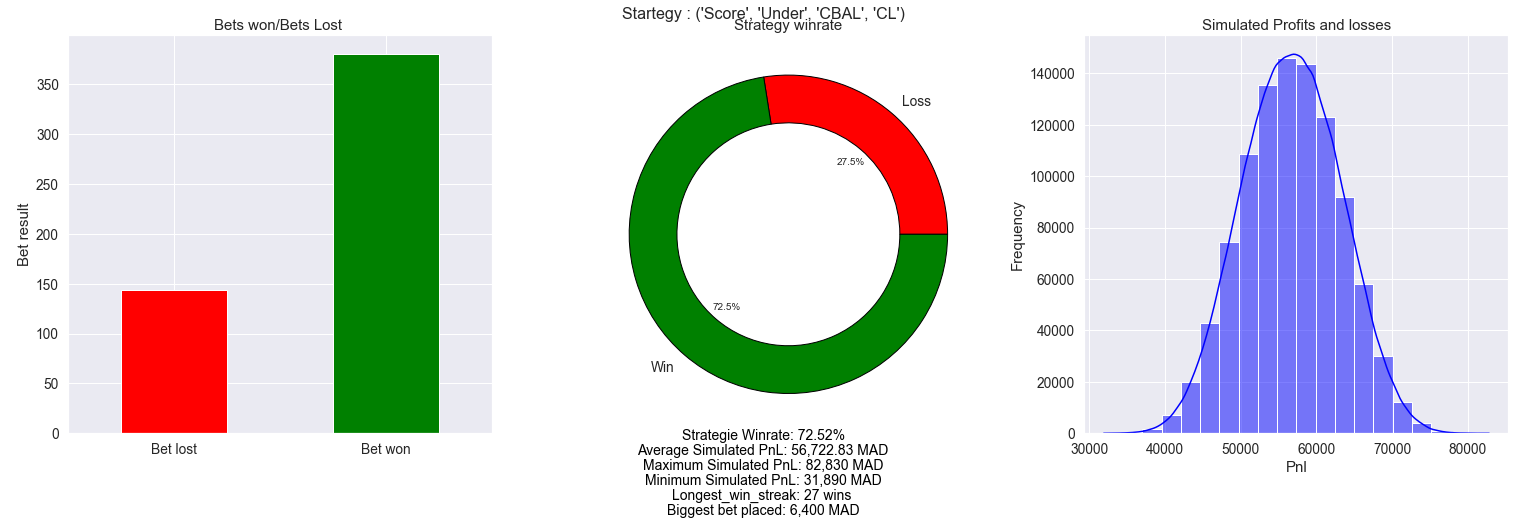

In [72]:

# Variables to loop through 
Betting_behavior_1_options = ["CBAW", "CBAL"]
Betting_behavior_2_options = ["FBA", "DDW", "CL"]
Bet_type_options = ["result", "Score"]

# Fixed  parameters
goals = 3
n_sim = 1000000
min_odd = 1.1
max_odd = 3.5
step = 0.1
initial_betting_amount = 100

# Loop through all combinations
for Bet_type in Bet_type_options : 
    if Bet_type in ["result"]:
                for initial_bet in ["Win","Loss"]:
                    for  Betting_behavior_1 in Betting_behavior_1_options:
                        for Betting_behavior_2 in Betting_behavior_2_options:
                            results_simulation(
    Bet_type, initial_bet, Betting_behavior_1, Betting_behavior_2, goals, n_sim, min_odd, max_odd, step, initial_betting_amount)
    elif Bet_type in ["Score"]:
                for initial_bet in ["Over","Under"]:
                    for  Betting_behavior_1 in Betting_behavior_1_options:
                        for Betting_behavior_2 in Betting_behavior_2_options:
                            results_simulation(
    Bet_type, initial_bet, Betting_behavior_1, Betting_behavior_2, goals, n_sim, min_odd, max_odd, step, initial_betting_amount)

**Findings:**

- **Definition of Winrate:**
  - Winrate is defined as the ratio of wins to losses, not considering the betting amount.
  - Influenced by three variables: bet type, initial bet, and betting behavior.

- **Variables Impacting Winrate:**
  - Winrate is influenced by the bet type, initial bet, and betting behavior 1 (pattern of changing bets).
  - The second betting behavior does not impact winrate but only affects PnL (Profit and Loss).

- **Scenarios Ranking Based on Winrate:**
  1. Score, Over, CBAL: 72.71%
  2. Score, Under, CBAL: 72.52%
  3. Result, Loss, CBAL: 67.37%
  4. Result, Win, CBAL: 67.6%
  5. Result, Win, CBAW: 62%
  6. Result, Loss, CBAW: 61.83%
  7. Score, Over, CBAW: 27.5%
  8. Score, Under, CBAW: 27.3%

- **Observations:**
  - Scenarios involving scores and CBAL generally have higher winrates compared to scenarios involving CBAW.
  - Notable differences in winrates among various scenarios, suggesting the importance of chosen parameters in betting strategy.

- **Considerations:**
  - Further analysis of why certain scenarios have higher winrates.
  - Understanding the relationship between winrate and PnL in the context of the second betting behavior for insights into overall profitability.





**Observations on Rankings:**

- **Role of Initial Bet:**
  - The initial bet doesn't play a crucial role in scenarios. Regardless of the starting bet, the subsequent bets ended up being the same after the first winning bet. The impact of the initial bet in the patterns can be considered null.

- **Performance of Bets on Result vs. Score:**
  - Bets on results generally have better overall performances. They consistently yield a positive winrate, unlike bets on the score, which, despite occupying the top two places, also occupy the last two places.

- **Impact of Changing Bets After a Win (CBAW):**
  - The top four places in the rankings are occupied by patterns with CBAW (Changing bet after a winning bet). This suggests that the preferable pattern for the first betting behavior is changing bets after a loss.

- **Viability of Changing Bets After a Win in Result Bets:**
  - Changing bets after a win remains viable in the case of betting on results because a draw is considered a win in both cases (with a difference in odds). The winrate drop is only around 5% between betting on score using CBAL and betting on score using CBAW. However, in betting on the score, winrates drop by nearly 50% because there isn't a case where the bet wins in both outcomes.

- **Security of Betting Types:**
  - Betting on result is generally more secure, especially if the bettor hasn't decided on the first betting behavior (CBAW or CBAL). If the betting behavior is CBAL, the best betting type is betting on the score.

- **Preference for Changing Bets After a Loss:**
  - In general, changing bets after a loss is better than changing bets after a win in all cases.

These observations provide insights into the dynamics of different betting scenarios, emphasizing the significance of certain patterns and betting types for achieving positive outcomes.


**Introduction of Betting Behavior 2:**

Introducing Betting Behavior 2, which refers to how the bettor changes the betting amount. This variable becomes a key factor in determining the profits and losses for each of the 24 scenarios. Betting Behavior 2 adds another layer of complexity to the analysis, as it addresses the strategy employed by the bettor in adjusting the betting amount based on certain conditions.

Understanding and analyzing Betting Behavior 2 alongside the existing variables (bet type, initial bet, and Betting Behavior 1) will provide a more comprehensive view of the betting patterns and their impact on the overall outcomes. This introduces a nuanced dimension to the evaluation of strategies, emphasizing the importance of both the type of bets placed and the dynamic nature of the betting amounts in shaping the profitability of each scenario.

As we delve into Betting Behavior 2, we aim to uncover how variations in the betting amounts contribute to the overall performance, further refining the strategies employed in the betting environment.


**Analysis of Scenarios with Negative Winrates:**

Starting with the scenarios that had negative winrates, specifically bets on the score and changing bets after each winning bet, the outcomes align with expectations. This pattern results in a 100% loss in cases of a fixed betting amount and doubling down on wins.

Interestingly, despite the low winrate, there is a possibility of these scenarios being profitable for a bettor who is chasing losses. However, a significant caveat arises and  the betting amount can easily escalate to astronomical numbers. This makes the pattern practically impossible for most individuals unless they can remain unfazed while betting such substantial amounts of money.

This observation highlights the inherent risk and impracticality associated with certain betting patterns, emphasizing the importance of considering not only winrates but also the feasibility and sustainability of the betting strategies employed.


**Analysis of Contradictory Betting Behaviors:**

Upon examining different scenarios, a notable observation emerges when combining CBAL as Behavior 1 with DDW as Behavior 2 and combining CBAW as Behavior 1 with CL as Behavior 2. These combinations lead to unnatural scenarios characterized by huge betting amounts. The justification lies in the contradictory nature of these paired behaviors.

- **Contradictory Aspects:**
  - CBAL and CL both have an interest in the next event being a loss.
  - CBAW and DDW both have an interest in the next event being a win.

- **Opposite Behaviors:**
  - CBAL and DDW, as well as CBAW and CL, can be considered nearly opposite behaviors due to their conflicting interests in the outcome of the next event.

- **Decision to Rule Out Scenarios:**
  - Given the contradictory aspect of these paired behaviors, it is decided to rule out all scenarios that combine CBAL as Behavior 1 with DDW as Behavior 2 and CBAW as Behavior 1 with CL as Behavior 2.

This decision aims to streamline the analysis by eliminating scenarios that may lead to impractical or unnatural outcomes, ensuring a more focused examination of betting strategies and their potential implications.


**Breakdown of Winning Scenarios:**

1. **100% Winning Scenarios (Ranked):**
    1. Score, Over, CBAL, CL
    2. Score, Under, CBAL, CL
    3. Result, Loss, CBAL, CL
    4. Result, Win, CBAL, CL
    5. Score, Over, CBAL, FBA
    6. Score, Under, CBAL, FBA
    7. Result, Loss, CBAL, FBA
    8. Result, Win, CBAL, FBA
    9. Result, Loss, CBAW, FBA
    10. Result, Win, CBAW, FBA

2. **Winning Scenarios with Some Losing Simulations:**
   1. Result, Loss  , CBAW, DDW
   2. Result, Win, CBAW, DDW

   *Note: Despite having some losing simulations, these scenarios, on average, yield more profits.*

It's crucial to emphasize that scenarios with negative winrates and those with contradictory behaviors have been ruled out due to being unrealistic or resulting in 100% losses. The focus is now on understanding and optimizing strategies within the identified winning scenarios.



**Conclusion:**

1. **Minimizing Risk:**
   - To guarantee a 100% winrate and minimize risk, adopting the strategy of changing bets after each loss is crucial. The condition is to refrain from doubling down on wins.

2. **Maximizing Wins with Risk Mitigation:**
   - For those seeking to maximize wins while still minimizing risk, pairing the strategy of changing bets after each loss with chasing losses provides a secure and winning approach.

3. **Maximizing Wins with Increased Risk:**
   - To achieve the dual goal of maximizing wins while accepting increased risk, the recommended strategy is pairing changing bets after each win with doubling down on bets, particularly when betting on results.

These conclusions provide valuable insights into different betting strategies, allowing individuals to tailor their approaches based on their risk tolerance, objectives, and desired outcomes. It's important to note that the effectiveness of strategies may vary based on individual preferences and the dynamic nature of betting environments.


## <center>**Conclusion**</center>

In this comprehensive data analysis of Morocco's football performance, we explored various aspects, including historical trends, tournament participation, game outcomes based on different factors, and potential betting scenarios. Here are the key takeaways:

1. **Historical Trends:**
   - Morocco's football history can be divided into distinct eras marked by fluctuating performance, golden periods, and moments of resurgence.

2. **Tournament Participation:**
   - The team's participation in different tournaments, including the World Cup and AFCON, reflected varying degrees of success, with notable achievements and challenges.

3. **Field Advantage:**
   - Results were significantly associated with the field advantage, emphasizing the impact of playing at home, away, or on neutral ground. Home games showed a higher probability of positive outcomes, possibly due to crowd support.

4. **Unexpected Observations:**
   - Some unexpected observations, such as winning more friendly away games than neutral ones, added nuance to our analysis, emphasizing the complexity of football dynamics.

5. **Betting Scenarios:**
   - Initial analysis of betting scenarios revealed positive winrates, prompting further exploration through simulation. Subsequent simulations involved random odds generation and varying betting amounts to assess the financial viability of each scenario with an additionnal variable ( Betting amount )


In summary, this data analysis provides valuable insights into Morocco's football history and performance, shedding light on factors influencing game outcomes and presenting potential betting strategies. The findings contribute to a comprehensive understanding of the team's journey and can offer a foundation for further exploration and predictions.